# Определение уязвимых групп населения

Задача:
* кластеризовать регионы России и определить, какие из них наиболее
остро нуждаются в помощи малообеспеченным/неблагополучным
слоям населения;
* описать группы населения, сталкивающиеся с бедностью;
* определить:
    * влияет ли число детей, пенсионеров и других социально уязвимых
групп на уровень бедности в регионе;
    * связаны ли уровень бедности/социального неблагополучия с
производством и потреблением в регионе;
    * какие ещё зависимости можно наблюдать относительно
социально незащищённых слоёв населения.

In [1]:
import pandas as pd
import numpy as np

Для начала работы загрузим список субъектов РФ с сайта [Wikipedia](https://ru.wikipedia.org/wiki/Коды_субъектов_Российской_Федерации) и преобразуем их словарь.

In [2]:
import requests
from bs4 import BeautifulSoup
import re

url = "https://ru.wikipedia.org/wiki/Коды_субъектов_Российской_Федерации"
regions = pd.read_html(requests.get(url).text, match='Наименование субъекта')[0]

regions['Наименование субъекта'] = regions['Наименование субъекта'].str.replace('\xa0', ' ')
regions = regions[regions['Наименование субъекта'] != 'Территории, находящиеся за пределами РФ и обслуживаемые Управлением режимных объектов МВД России, Байконур']
regions =regions.drop(['Код ГИБДД', 'Код ОКАТО и ОКТМО', 'Код ISO 3166-2[1]', 'Код ГОСТ 7.67-2003'], axis=1)

regions_to_delete = ['Ханты-Мансийский автономный округ — Югра', 'Ямало-Ненецкий автономный округ', 'Тюменская область', 'Ненецкий автономный округ', 'Архангельская область', 'Омская область']
cleaned_regions = regions[~regions['Наименование субъекта'].isin(regions_to_delete)]

def short_regions(region):
    replace_dict = {'республика':'', 'автономная':'','край':'', 'область':'', 'автономный округ':'','народная':'', 'северная':'', 'автономная область':'', 'эл':'', '(':',', ')':'', ' — ':',',' - ':',',' ':''}
    reg_replace = {'саха': "республика саха", "алтай": "республика алтай", "коми": "республика коми"}
    for old, new in replace_dict.items():
        region = region.lower().replace(old, new)
            
    region = region.split(',')
    
    for key in reg_replace:
        if key in region:
            region.remove(key)
            region.append(reg_replace[key])
    return region

cleaned_regions['short'] = cleaned_regions['Наименование субъекта'].apply(short_regions)

regions_dict = {element: row['Наименование субъекта'] for _, row in cleaned_regions.iterrows() for element in row['short']}
regions_dict.update({'санкт':'Санкт-Петербург', 
                     'bладимирская': 'Владимирская область',
                     'bоронежская':'Воронежская область',
                     'bологодская':'Вологодская область',
                     'bолгоградская область':'Волгоградская область',
                     'тюменская область без автономного округа':'Тюменская область',
                     'тюменская область без\nавтономных округов':'Тюменская область',
                     'юменская обл.без данных по':'Тюменская область',
                     'рхангельская обл. без данных по':'Архангельская область',
                     'юменская область (кроме': 'Тюменская область',
                     'рхангельская область (кроме': 'Архангельская область'})

/var/folders/q_/7gwj_d0j19x6bt29_k4ngwl40000gq/T/ipykernel_69397/435800990.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  regions = pd.read_html(requests.get(url).text, match='Наименование субъекта')[0]
/var/folders/q_/7gwj_d0j19x6bt29_k4ngwl40000gq/T/ipykernel_69397/435800990.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_regions['short'] = cleaned_regions['Наименование субъекта'].apply(short_regions)


In [3]:
# Функция для преобразования наименований субъектов:

def change_name(name):
    name_lower = name.lower()

    for n, region in regions_dict.items():
        if n in name_lower:
            return region

    if re.search(r'\bомская\b(?!.*томская)', name_lower):
        return "Омская область"

    if any(keyword in name_lower for keyword in ['ханты', 'югра']):
        return 'Ханты-Мансийский автономный округ — Югра'
    elif 'ямало' in name_lower:
        return 'Ямало-Ненецкий автономный округ'
    elif 'тюменская' in name_lower:
        return 'Тюменская область'

    if all(keyword in name_lower for keyword in ['ненецкий', 'архангельск']):
        return "Ненецкий автономный округ"
    elif re.search(r'\bненецкий\b', name_lower) and not re.search(r'\bямало-ненецкий\b', name_lower):
        return "Ненецкий автономный округ"
    elif 'архангельск' in name_lower:
        return "Архангельская область"

    print(f"No match found for '{name_lower}'")
    return name

## 1. Обработка данных

### 1.1. Подгрузка данных из таблиц

#### 1.1.1 Доходы населения

In [4]:
#Среднедущевые доходы населения

cash_capita = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx')

# Исключим строки содержащие федеральный округ, федерация и район
district = cash_capita[cash_capita['region'].str.contains('федеральный округ|Федерация|район|числе')].index
cash_capita.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
cash_capita['region'] = cash_capita['region'].apply(change_name)

cash_capita.set_index('region', inplace=True)
cash_capita = cash_capita[~cash_capita.index.duplicated(keep='last')]

print('Среднедушевые денежные доходы (в месяц), руб')
cash_capita.head()

Среднедушевые денежные доходы (в месяц), руб


,2015,2016,2017,2018,2019,2020
region,,,,,,
Белгородская область,28043.0,29799.0,30342.0,30778.0,32352.0,32841.0
Брянская область,23428.0,24006.0,25107.0,26585.0,28371.0,28596.0
Владимирская область,22712.0,22365.0,23554.0,23539.0,25358.0,25922.0
Воронежская область,29366.0,29284.0,29498.0,30289.0,32022.0,32078.0
Ивановская область,22297.0,23676.0,24860.0,24503.0,25794.0,26277.0


In [5]:
# Реальные доходы населения

real_incomes = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', 1)

# Исключим строки содержащие федеральный округ, федерация и район
district = real_incomes[real_incomes['region'].str.contains('федеральный округ|Федерация|район|числе')].index
real_incomes.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
real_incomes['region'] = real_incomes['region'].apply(change_name)

real_incomes.set_index('region', inplace=True)
real_incomes = real_incomes[~real_incomes.index.duplicated(keep='last')]

print('Реальные денежные доходы (в месяц), руб')
real_incomes.head()

Реальные денежные доходы (в месяц), руб


,2015,2016,2017,2018,2019,2020
region,,,,,,
Белгородская область,99.3,100.8,99.1,98.7,100.6,98.1
Брянская область,97.0,95.0,99.4,102.1,100.5,96.3
Владимирская область,99.5,92.2,100.9,96.4,101.9,98.0
Воронежская область,101.1,93.6,97.4,100.0,101.1,95.4
Ивановская область,95.5,98.5,100.4,94.4,99.5,97.2


In [6]:
# Номинальная заработная плата

formal_wage_paid = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', 2)

# Исключим строки содержащие федеральный округ, федерация и район
district = formal_wage_paid[formal_wage_paid['region'].str.contains('федеральный округ|Федерация|район|числе')].index
formal_wage_paid.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
formal_wage_paid['region'] = formal_wage_paid['region'].apply(change_name)

formal_wage_paid.set_index('region', inplace=True)
formal_wage_paid = formal_wage_paid[~formal_wage_paid.index.duplicated(keep='last')]

print('Номинальная заработная плата (в месяц), руб')
formal_wage_paid.head()

Номинальная заработная плата (в месяц), руб


,2015,2016,2017,2018,2019,2020
region,,,,,,
Белгородская область,25456.0,27091.0,29066.0,31852.0,34615.0,37442.0
Брянская область,21679.0,22923.0,24743.0,27251.0,29853.0,31946.0
Владимирская область,23877.0,25135.0,26975.0,30460.0,33076.0,35240.0
Воронежская область,24906.0,26335.0,28007.0,31207.0,33690.0,36317.0
Ивановская область,21161.0,22144.0,23470.0,25729.0,27553.0,29083.0


In [7]:
# Реальная заработная плата

real_pay = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', 2)

# Исключим строки содержащие федеральный округ, федерация и район
district = real_pay[real_pay['region'].str.contains('федеральный округ|Федерация|район|числе')].index
real_pay.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
real_pay['region'] = real_pay['region'].apply(change_name)

real_pay.set_index('region', inplace=True)
real_pay = real_pay[~real_pay.index.duplicated(keep='last')]

print('Реальная заработная плата (в месяц), руб')
real_pay.head()

Реальная заработная плата (в месяц), руб


,2015,2016,2017,2018,2019,2020
region,,,,,,
Белгородская область,25456.0,27091.0,29066.0,31852.0,34615.0,37442.0
Брянская область,21679.0,22923.0,24743.0,27251.0,29853.0,31946.0
Владимирская область,23877.0,25135.0,26975.0,30460.0,33076.0,35240.0
Воронежская область,24906.0,26335.0,28007.0,31207.0,33690.0,36317.0
Ивановская область,21161.0,22144.0,23470.0,25729.0,27553.0,29083.0


#### 1.1.2. Число умерших на первом году жизни детей за год

In [8]:
# Детская смертность в сельской местности

rural = pd.read_excel('data/child_mortality_rural_1990_2021.xls', skiprows=2)

# Удалим лишние столбцы
rural.drop(['Unnamed: 1', 'Unnamed: 2'], axis = 1, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = rural[rural['Unnamed: 0'].str.contains('федеральный округ|Федерация|район|Ордынский|Корякский|кроме|Коми-Пермяцкий|(Красноярский край)|Агинский')].index
# Удаляем пробелы перед названием регионов
rural['Unnamed: 0'] = rural['Unnamed: 0'].str.strip()
rural.drop(district, axis = 0, inplace=True)

rural.rename(columns={'Unnamed: 0':"region"}, inplace=True)

# Унифицируем названия регионов
rural['region'] = rural['region'].apply(change_name)

rural.set_index('region', inplace=True)
rural = rural[~rural.index.duplicated(keep='first')]

/var/folders/q_/7gwj_d0j19x6bt29_k4ngwl40000gq/T/ipykernel_69397/145083697.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  district = rural[rural['Unnamed: 0'].str.contains('федеральный округ|Федерация|район|Ордынский|Корякский|кроме|Коми-Пермяцкий|(Красноярский край)|Агинский')].index


In [9]:
# Детская смертность в городской местности

urban = pd.read_excel('data/child_mortality_urban_1990_2021.xls', skiprows=2)

# Удалим лишние столбцы
urban.drop(['Unnamed: 1', 'Unnamed: 2'], axis = 1, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = urban[urban['Unnamed: 0'].str.contains('федеральный округ|Федерация|район|Ордынский|Корякский|кроме|Коми-Пермяцкий|(Красноярский край)|Агинский')].index
# Удаляем пробелы перед названием регионов
urban['Unnamed: 0'] = urban['Unnamed: 0'].str.strip()
urban.drop(district, axis = 0, inplace=True)

urban.rename(columns={'Unnamed: 0':"region"}, inplace=True)

# Унифицируем названия регионов
urban['region'] = urban['region'].apply(change_name)

urban.set_index('region', inplace=True)
urban = urban[~urban.index.duplicated(keep='first')]

# Объединяем детскую смертность с городов и регионов
child_mortality = rural.add(urban)
print('Количетсво умерших детей, чел.')
child_mortality.head()

Количетсво умерших детей, чел.


/var/folders/q_/7gwj_d0j19x6bt29_k4ngwl40000gq/T/ipykernel_69397/2198150413.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  district = urban[urban['Unnamed: 0'].str.contains('федеральный округ|Федерация|район|Ордынский|Корякский|кроме|Коми-Пермяцкий|(Красноярский край)|Агинский')].index


,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
region,,,,,,,,,,,,,,,,,,,,,
Белгородская область,312.0,290.0,240.0,244.0,233.0,203.0,174.0,167.0,160.0,161.0,...,127.0,116.0,103.0,110.0,108.0,77.0,73.0,39.0,47.0,54.0
Брянская область,322.0,304.0,283.0,297.0,256.0,229.0,212.0,202.0,182.0,184.0,...,127.0,124.0,126.0,111.0,103.0,96.0,45.0,37.0,41.0,27.0
Владимирская область,301.0,267.0,239.0,210.0,211.0,196.0,161.0,161.0,169.0,174.0,...,127.0,117.0,110.0,107.0,100.0,76.0,67.0,58.0,61.0,66.0
Воронежская область,399.0,441.0,418.0,362.0,348.0,321.0,273.0,275.0,302.0,280.0,...,166.0,186.0,145.0,126.0,120.0,108.0,99.0,81.0,70.0,83.0
Ивановская область,255.0,231.0,214.0,225.0,192.0,182.0,159.0,166.0,137.0,160.0,...,71.0,86.0,68.0,64.0,66.0,35.0,35.0,40.0,28.0,24.0


#### 1.1.3 Люди с инвалидностью

In [10]:
disabled = pd.read_csv('data/disabled_total_by_age_2017_2022.csv')

# Исключаем строки содержащие федеральный округ, федерация и район
district = disabled[disabled['region'].str.contains('федеральный округ|Федерация|район|Байконур')].index
disabled.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
disabled['region'] = disabled['region'].apply(change_name)

disabled.set_index('region', inplace=True)

# Выполняем группировку по году
disabled['date'] = pd.to_datetime(disabled['date']).dt.year
disabled = disabled.groupby(['region','date'])['total'].sum().unstack()

print('Количество инвалидов, чел.')
disabled.head()

Количество инвалидов, чел.


date,2017,2018,2019,2020,2021,2022
region,,,,,,
Алтайский край,1987350.0,2120203.0,2100077.0,2060817.0,1986766.0,646296.0
Амурская область,816315.0,797050.0,785693.0,766768.0,733732.0,236444.0
Архангельская область,1056888.0,1038542.0,1031766.0,1016584.0,978993.0,316492.0
Астраханская область,533426.0,525601.0,523200.0,520687.0,511039.0,167664.0
Белгородская область,2625755.0,2522995.0,2446166.0,2359129.0,2252362.0,723760.0


#### 1.1.4 Сведения о заболеваемости алкоголизмом и наркоманией

In [11]:
alco = pd.read_excel('data/drug_alco.xlsx', 0)
alco1718 = pd.read_excel('data/drug_alco.xlsx', 1)

# Исключаем строки содержащие федеральный округ, федерация и район
district = alco[alco['region'].str.contains('федеральный округ|Федерация|район|Байконур')].index
alco.drop(district, axis = 0, inplace=True)
district = alco1718[alco1718['region'].str.contains('федеральный округ|Федерация|район|Байконур|медицинское')].index
alco1718.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
alco['region'] = alco['region'].apply(change_name)
alco1718['region'] = alco1718['region'].apply(change_name)

alco.set_index('region', inplace=True)
alco1718.set_index('region', inplace=True)

alco = pd.concat([alco, alco1718], axis=1).sort_index()

print('Количество человек с алкогольной зависимостью поставленных на учёт на 100 тысяч человек')
display(alco.head())

Количество человек с алкогольной зависимостью поставленных на учёт на 100 тысяч человек


,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
region,,,,,,,,,,,,,,
Алтайский край,227.6,202.4,173.9,199.8,177.9,164.0,157.6,138.9,105.0,111.9,115.7,100.1,85.9,88.1
Амурская область,174.3,159.0,120.9,113.3,115.5,140.5,124.7,104.8,100.0,96.7,97.2,92.3,91.4,113.3
Архангельская область,120.1,115.2,102.5,89.8,96.5,99.5,84.4,73.2,77.6,NaN,NaN,NaN,55.3,64.7
Астраханская область,137.1,166.0,130.3,116.1,134.5,113.4,91.7,84.7,61.8,NaN,NaN,NaN,26.2,22.2
Белгородская область,99.6,93.2,84.0,92.3,94.3,86.4,72.6,74.8,66.9,56.8,50.7,46.1,45.2,41.3


In [12]:
drugs = pd.read_excel('data/drug_alco.xlsx', 2)
drugs1718 = pd.read_excel('data/drug_alco.xlsx', 3)

# Исключаем строки содержащие федеральный округ, федерация и район
district = drugs[drugs['region'].str.contains('федеральный округ|Федерация|район|Байконур')].index
drugs.drop(district, axis = 0, inplace=True)
district = drugs1718[drugs1718['region'].str.contains('федеральный округ|Федерация|район|Байконур|медицинское')].index
drugs1718.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
drugs['region'] = drugs['region'].apply(change_name)
drugs1718['region'] = drugs1718['region'].apply(change_name)

drugs.set_index('region', inplace=True)
drugs1718.set_index('region', inplace=True)

drugs = pd.concat([drugs, drugs1718], axis=1).sort_index()

print('Количество человек с наркотической зависимостью поставленных на учёт на 100 тысяч человек')
drugs.head()

Количество человек с наркотической зависимостью поставленных на учёт на 100 тысяч человек


,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
region,,,,,,,,,,,,,,
Алтайский край,29.8,35.2,35.2,37.7,27.3,24.5,26.4,33.4,22.9,21.6,20.7,17.4,17.4,17.4
Амурская область,21.3,27.2,27.2,28.4,26.2,37.1,33.9,24.2,22.5,22.2,19.1,18.9,18.7,24.4
Архангельская область,1.5,1.4,1.4,2.6,3.4,4.6,6.4,4.0,4.0,NaN,NaN,NaN,5.4,9.2
Астраханская область,10.7,12.9,12.9,6.8,8.1,9.8,7.5,5.1,2.3,NaN,NaN,NaN,0.7,0.2
Белгородская область,4.5,9.5,9.5,4.2,3.9,4.8,4.0,2.3,2.4,1.9,2.0,1.6,2.3,3.2


#### 1.1.5 Валовой региональный продукт на душу населения, в рублях.

In [13]:
grass = pd.read_excel('data/gross_regional_product_1996_2020.xls', 
                      header=2)

# Исключим строки содержащие федеральный округ, федерация и район
district = grass[grass['Unnamed: 0'].str.contains('федеральный округ|Федерация|район|кроме')].index
# Удаляем пробелы перед названием регионов
grass['Unnamed: 0'] = grass['Unnamed: 0'].str.strip()
grass.drop(district, axis = 0, inplace=True)

grass.rename(columns={'Unnamed: 0':"region"}, inplace=True)

# Унифицируем названия регионов
grass['region'] = grass['region'].apply(change_name)

grass.set_index('region', inplace=True)

print('Валовой региональный продукт на душу населения, в рублях.')
grass.head()

Валовой региональный продукт на душу населения, в рублях.


,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
region,,,,,,,,,,,,,,,,,,,,,
Белгородская область,9575.6,10792.2,12242.8,21398.0,27969.5,33126.7,41327.4,50271.4,75629.4,95911.2,...,331010.0,354570.6,368874.8,400820.8,447619.7,501467.8,539720.5,588641.5,617426.5,646569.0
Брянская область,7275.3,7175.7,7659.1,11752.4,17413.5,21511.9,27020.0,31953.4,37719.1,49923.4,...,137187.1,164726.6,175865.0,196096.7,221080.0,258752.7,280630.1,304547.1,332442.8,347204.5
Владимирская область,7620.7,8431.3,9350.2,15457.1,21073.3,27170.0,32923.6,40809.4,49353.4,58261.0,...,181842.6,200456.4,216320.8,232757.6,262945.5,309713.7,325043.1,349856.4,394560.3,410443.6
Воронежская область,7651.9,8686.6,9082.1,14808.3,20365.1,24905.4,34789.6,42237.5,49530.0,56534.5,...,203575.5,241947.4,262578.3,308004.7,345566.8,354657.9,374125.7,408140.7,431037.0,459629.5
Ивановская область,6725.4,6379.3,6804.5,9765.2,14240.0,18947.2,23396.9,29192.4,35732.7,40039.1,...,121945.5,129448.3,151263.6,146032.6,174687.5,200504.4,208522.0,230325.5,249591.6,273821.5


#### 1.1.6 Оценка домохозяйствами состояния занимаемого ими жилого помещения

In [14]:
housing = pd.read_excel('data/housing_2020.xlsx')

housing.rename(columns={'Регион':"region"}, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = housing[housing['region'].str.contains('федеральный округ|Федерация|район')].index
housing.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
housing['region'] = housing['region'].apply(change_name)

housing.set_index('region', inplace=True)

housing_conditions = pd.read_excel('data/housing_2020.xlsx', 1)
housing_conditions.rename(columns={'Регион':"region"}, inplace=True)

housing_conditions = housing_conditions.dropna(subset=['region'])

# Исключим строки содержащие федеральный округ, федерация и район
district = housing_conditions[housing_conditions['region'].str.contains('федеральный округ|Федерация|район|здесь и далее')].index
housing_conditions.drop(district, axis = 0, inplace=True)

housing_conditions['region'] = housing_conditions['region'].apply(lambda x: x.replace('B','В'))

# Унифицируем названия регионов
housing_conditions['region'] = housing_conditions['region'].apply(change_name)

housing_conditions.set_index('region', inplace=True)

print('Средняя жилая площадь на человека, м^2')
living_area = housing[['Размер жилой площади в расчете на члена домохозяйства']]
display(living_area.head())

print('Плохие условия проживания')
# ВЫбираем столбец с плохими условиями
poor_living_conditions = housing_conditions[['из них указавшие: на плохое состояние или очень плохое состояние жилого помещения и на стесненность проживания']]
# Удалаям последнюю строку
poor_living_conditions = poor_living_conditions.drop(poor_living_conditions.index[-1])
poor_living_conditions.rename(columns={'из них указавшие: на плохое состояние или очень плохое состояние жилого помещения и на стесненность проживания':'poor_living'}, inplace=True)
display(poor_living_conditions.head())

Средняя жилая площадь на человека, м^2


,Размер жилой площади в расчете на члена домохозяйства
region,
Белгородская область,17.8
Брянская область,24.1
Владимирская область,16.1
Воронежская область,19.9
Ивановская область,18.1


Плохие условия проживания


,poor_living
region,
Белгородская область,0.4
Брянская область,0.0
Владимирская область,0.0
Воронежская область,0.1
Ивановская область,0.9


#### 1.1.7 Заболеваемость

In [15]:
diseases = pd.read_excel('data/morbidity_2005_2020_age_disease.xls', skiprows=2)
diseases.rename(columns={'Unnamed: 0':"region",'Unnamed: 1':"Заболевания",'Unnamed: 2':"Группа"}, inplace=True)


# Исключим строки содержащие федеральный округ, федерация и район
district = diseases[diseases['region'].str.contains('федеральный округ|Федерация|район')].index
# Удаляем пробелы перед названием регионов
diseases['region'] = diseases['region'].str.strip()
diseases.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
diseases['region'] = diseases['region'].apply(change_name)

# Назначим регион как индекс
diseases.set_index('region', inplace=True)
diseases = diseases[diseases['Группа'] == 'Всего']

# Выделим статистику по общем заболиваемости
general_morbidity = diseases[diseases['Заболевания'].isin(['Все заболевания'])].loc[:,['2015', '2016','Заболевания']]
general_morbidity = general_morbidity.dropna(axis=0)
general_morbidity = general_morbidity.groupby(['region','Заболевания'])[['2015', '2016']].sum().unstack()
print('Статистика по общей заболиваемости')
general_morbidity.head()

Статистика по общей заболиваемости


,2015,2016
Заболевания,Все заболевания,Все заболевания
region,,
Алтайский край,109652.6,112764.7
Амурская область,83919.0,83412.0
Архангельская область,101587.4,99842.1
Астраханская область,62055.8,64679.9
Белгородская область,70736.1,74637.4


#### 1.1.8 Подростковая беременность

In [16]:
diseases = pd.read_excel('data/morbidity_2005_2020_age_disease.xls', skiprows=2)
diseases.rename(columns={'Unnamed: 0':"region",'Unnamed: 1':"Заболевания",'Unnamed: 2':"Группа"}, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = diseases[diseases['region'].str.contains('федеральный округ|Федерация|район')].index
# Удаляем пробелы перед названием регионов
diseases['region'] = diseases['region'].str.strip()
diseases.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
diseases['region'] = diseases['region'].apply(change_name)

# Назначим регион как индекс
diseases.set_index('region', inplace=True)
pregnancy = diseases[diseases['Заболевания'] == 'Беременность, роды и послеродовой период']

# Объеденим значения с таблиц по беременности детей до 14 и до 17 лет.
pregnancy_14 = pregnancy[pregnancy['Группа'] == '0-14 лет'].copy()
pregnancy_17 = pregnancy[pregnancy['Группа'] == '15-17 лет'].copy()

pregnancy_14.drop(['Группа', 'Заболевания'], axis = 1, inplace=True)
pregnancy_17.drop(['Группа', 'Заболевания'], axis = 1, inplace=True)
teen_pregnancy = pregnancy_14.add(pregnancy_17, fill_value=0)

# Удалим статистику до 2014 года, до 2014 года статистика велаась без автономных округов
teen_pregnancy.drop(['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013'], axis = 1, inplace=True)
teen_pregnancy = teen_pregnancy[~teen_pregnancy.index.duplicated(keep='last')]
print('Подростковая беременность, чел. на 100 тыс. человек')
display(teen_pregnancy.head())

Подростковая беременность, чел. на 100 тыс. человек


,2014,2015,2016
region,,,
Белгородская область,1264.7,1227.3,875.6
Брянская область,1076.7,862.7,705.5
Владимирская область,1771.9,1442.4,856.4
Воронежская область,553.1,369.8,272.0
Ивановская область,1023.5,542.5,491.3


#### 1.1.9 Рождаемость

In [17]:
import regex as re

standard_names = regions_dict.copy()

newborn = pd.read_csv(
    'data/newborn_2006_2022_monthly.csv', sep=';', decimal=',')
newborn.rename({'Region': 'region'}, axis=1, inplace=True)
names_to_drop = [
    'Архангельская область (кроме Ненецкого автономного округа)',
    'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)',
    'Московская обл. в старых границах',
    'Москва в старых границах'
]

# Исключим строки содержащие федеральный округ, федерация и район
district = newborn[newborn['region'].str.contains('федеральный округ|Федерация|район|Ордынский|Корякский|Коми-Пермяцкий|кроме|в старых границах|(Красноярский край)|Агинский')].index
newborn.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
newborn['region'] = newborn['region'].apply(change_name)

# Назначим регион как индекс
newborn.set_index('region', inplace=True)
    
# Суммируем данные за год
for year in range(2006, 2023):
    cols = []
    for col in newborn.columns:
        if str(year) in str(col):
            cols.append(col)
    newborn[year] = newborn[cols].sum(axis=1)
    newborn.drop(columns=cols, inplace=True)
newborn.drop(columns=2022, inplace=True)  # Неполный год

print('Рождённые в этом месяце, по регионам, без учёта мертворождённых')
newborn.head()

Рождённые в этом месяце, по регионам, без учёта мертворождённых


/var/folders/q_/7gwj_d0j19x6bt29_k4ngwl40000gq/T/ipykernel_69397/3854046276.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  district = newborn[newborn['region'].str.contains('федеральный округ|Федерация|район|Ордынский|Корякский|Коми-Пермяцкий|кроме|в старых границах|(Красноярский край)|Агинский')].index


,Unnamed: 198,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
region,,,,,,,,,,,,,,,,,
Белгородская область,NaN,14269.0,15666.00,16810.00,16911.00,16669.00,16894.00,17913.00,17883.00,17822.00,17864.00,17261.0,15113.00,14318.00,13197.99,12351.99,12223.0
Брянская область,NaN,12042.0,13282.99,14319.00,14406.00,13773.00,13806.00,14376.00,13855.00,13657.99,14067.00,13379.0,11552.99,11124.00,10028.00,9480.00,9047.0
Владимирская область,NaN,13915.0,14679.00,15699.00,15520.00,15540.00,15644.00,16445.00,15777.00,15817.00,16284.00,15662.0,13395.00,12658.00,11158.00,10120.00,9780.0
Воронежская область,NaN,19208.0,20568.99,22421.99,23560.99,23819.99,23826.97,25373.99,24980.97,25331.99,25923.98,24938.0,22423.00,21381.99,19643.00,19161.00,18593.0
Ивановская область,NaN,9818.0,10617.00,11138.00,11329.98,11131.00,11035.00,11581.00,11769.00,11694.97,11761.00,11184.0,9877.00,9134.00,7951.00,7563.00,7327.0


#### 1.1.10 Население

In [18]:
population = pd.read_excel('data/population.xlsx')

population = population.rename(columns={'Unnamed: 0': 'region'})
population['region']=population['region'].fillna('region_')

population = population.bfill()

# Исключим строки содержащие федеральный округ, федерация и район
district = population[population['region'].str.contains('федеральный округ|Федерация|район|Раздел 1.|все население|Муниципа|муниципа|сельсовет|поссовет|рп|Ордынский|Корякский|region|Коми-Пермяцкий|кроме|Агинский|(Красноярский край)')].index
population.drop(district, axis = 0, inplace=True)
population.drop('Unnamed: 1', axis=1, inplace=True)

# Унифицируем названия регионов
population['region'] = population['region'].apply(change_name)

# Назначим регион как индекс
population.set_index('region', inplace=True)

population.columns = range(1999,2023)
population = pd.DataFrame(population[2022])
population = population.rename(columns={2022: 'population'})

print('Численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2022 ')
population

Численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2022 


/var/folders/q_/7gwj_d0j19x6bt29_k4ngwl40000gq/T/ipykernel_69397/2183043562.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  district = population[population['region'].str.contains('федеральный округ|Федерация|район|Раздел 1.|все население|Муниципа|муниципа|сельсовет|поссовет|рп|Ордынский|Корякский|region|Коми-Пермяцкий|кроме|Агинский|(Красноярский край)')].index


,population
region,
Белгородская область,1531917
Брянская область,1168771
Владимирская область,1323659
Воронежская область,2287678
Ивановская область,976918
...,...
Амурская область,772525
Магаданская область,137767
Сахалинская область,484177


#### 1.1.11 Процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума), оценка за год по регионам

In [19]:
poverty_percent = pd.read_csv('data/poverty_percent_by_regions_1992_2020.csv')
poverty_percent = pd.pivot_table(data=poverty_percent, 
        values='poverty_percent', columns='year', index='region').reset_index()

# Исключим строки содержащие федеральный округ, федерация и район
district = poverty_percent[poverty_percent['region'].str.contains('федеральный округ|Федерация|район|кроме')].index
# Удаляем пробелы перед названием регионов
poverty_percent['region'] = poverty_percent['region'].str.strip()
poverty_percent.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
poverty_percent['region'] = poverty_percent['region'].apply(change_name)

# Назначим регион как индекс
poverty_percent.set_index('region', inplace=True)

print('Процент людей, живущих за чертой бедности')
poverty_percent.head(3)

Процент людей, живущих за чертой бедности


year,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
region,,,,,,,,,,,,,,,,,,,,,
Ненецкий автономный округ,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,37.9,26.9,...,7.7,6.5,7.8,8.9,9.4,10.1,10.6,9.7,9.4,9.4
Ханты-Мансийский автономный округ — Югра,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,11.8,9.3,...,10.6,9.8,10.4,11.1,11.9,11.6,9.5,9.0,8.9,8.4
Ямало-Ненецкий автономный округ,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,11.1,9.3,...,7.4,6.4,6.4,6.7,7.5,7.1,6.1,5.8,5.5,4.8


#### 1.1.12 Распределение малоимущего населения по социально-демографическим группам

In [20]:
def socdem(x):
    """Изменяем название столбца с регионами, приводим название регионов
    к общему виду.

    Args:
        x (xls): таблица с данными
    Returns:
        DataFrame: изменнённый датафрейм
    """
    df = pd.read_excel(x, header=2)
    df.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    district = df[df['region'].str.contains('федеральный округ|Федерация|район')].index
    # Удаляем пробелы перед названием регионов
    df['region'] = df['region'].str.strip()
    df.drop(district, axis = 0, inplace=True)
    df['region'] = df['region'].apply(change_name)
    df.set_index('region', inplace=True)
    return df

poverty_socdem_2017 = socdem(
    'data/poverty_socdem_2017.xls')
poverty_socdem_2018 = socdem(
    'data/poverty_socdem_2018.xls')
poverty_socdem_2019 = socdem(
    'data/poverty_socdem_2019.xls')
poverty_socdem_2020 = socdem(
    'data/poverty_socdem_2020.xls')

# Приведём всё к одному датафрейму, 
#заменим пропуски и нули значениями из прошлый таблиц
proverty_socdem = poverty_socdem_2020.replace({0: np.nan}).combine_first(poverty_socdem_2019)
proverty_socdem = proverty_socdem.replace({0:np.nan}).combine_first(poverty_socdem_2018)
proverty_socdem = proverty_socdem.replace({0:np.nan}).combine_first(poverty_socdem_2017)

proverty_socdem = proverty_socdem[~proverty_socdem.index.duplicated(keep='last')]

print('Процентное соотношение малоимущего населения по группам')
proverty_socdem.head()

Процентное соотношение малоимущего населения по группам


,Все население,Дети в возрасте до 16 лет,Население старше трудоспособного возраста,Население трудоспособного возраста
region,,,,
Белгородская область,100,44.8,12.9,42.3
Брянская область,100,44.8,3.7,51.6
Владимирская область,100,34.8,4.8,60.4
Воронежская область,100,28.5,2.3,69.2
Ивановская область,100,47.5,5.0,47.5


#### 1.1.13 Объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами.

In [21]:
reg_prod = pd.read_csv('data/regional_production_2017_2020.csv')

# Исключим строки содержащие федеральный округ, федерация и район
district = reg_prod[reg_prod['region'].str.contains('федеральный округ|Федерация|район')].index
# Удаляем пробелы перед названием регионов
reg_prod['region'] = reg_prod['region'].str.strip()
reg_prod.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
reg_prod['region'] = reg_prod['region'].apply(change_name)

# Назначим регион как индекс
reg_prod.set_index('region', inplace=True)


# Выделим датафрейм с показателем по добыче полезных ископаемых
reg_mining = reg_prod[reg_prod['production_field'] == 'ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ'].loc[:,'2017':'2020']
reg_mining = reg_mining[~reg_mining.index.duplicated(keep='last')]
# Выделим датафрейм с показателем по обеспечения электроэнергией
reg_electric = reg_prod[reg_prod['production_field'] == 'ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА'].loc[:,'2017':'2020']
reg_electric= reg_electric[~reg_electric.index.duplicated(keep='last')]
# Выделим показатель водоснабжения, утилизации отходов и ликвидации загрязнений
reg_water = reg_prod[reg_prod['production_field'] == 'ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ'].loc[:,'2017':'2020']
reg_water = reg_water[~reg_water.index.duplicated(keep='last')]
# Выделим датафрейм с показателем по обрабатывающим производствам
reg_manuf = reg_prod[reg_prod['production_field'] == 'ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА'].loc[:,'2017':'2020']
reg_manuf = reg_manuf[~reg_manuf.index.duplicated(keep='last')]
# Выделим датафрейм с показателем по промышленности
reg_indust = reg_prod[reg_prod['production_field'] == 'Промышленное производство (промышленность)'].loc[:,'2017':'2020']
reg_indust = reg_indust[~reg_indust.index.duplicated(keep='last')]

print('Добыча полезных ископаемых, в тысячах рублей: ')
display(reg_mining.head(2))
print('ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА, в тысячах рублей:')
display(reg_electric.head(2))
print('ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ, в тысячах рублей:')
display(reg_water.head(2))
print('ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА, в тысячах рублей:')
display(reg_manuf.head(2))
print('Промышленное производство (промышленность), в тысячах рублей:')
display(reg_indust.head(2))

Добыча полезных ископаемых, в тысячах рублей: 


,2017,2018,2019,2020
region,,,,
Белгородская область,116588313.5,148863422.7,178389894.9,189803813.7
Брянская область,277427.7,261549.5,338027.3,310665.9


ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА, в тысячах рублей:


,2017,2018,2019,2020
region,,,,
Белгородская область,27030715.9,26805485.3,26542583.5,26787381.9
Брянская область,16064108.9,17730258.7,17708749.5,17876399.5


ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ, в тысячах рублей:


,2017,2018,2019,2020
region,,,,
Белгородская область,10614103.8,8936415.0,11404169.8,11175025.3
Брянская область,7347143.3,8901072.7,9258735.3,9588966.4


ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА, в тысячах рублей:


,2017,2018,2019,2020
region,,,,
Белгородская область,629092604.8,7.108288e+08,7.226997e+08,7.463807e+08
Брянская область,191018941.6,2.185441e+08,2.536616e+08,2.556862e+08


Промышленное производство (промышленность), в тысячах рублей:


,2017,2018,2019,2020
region,,,,
Белгородская область,783325738.0,8.954341e+08,9.390364e+08,9.741469e+08
Брянская область,214707621.5,2.454370e+08,2.809671e+08,2.834622e+08


#### 1.1.14 Оборот розничной торговли на душу населения, в рублях.

In [22]:
retail = pd.read_excel('data/retail_turnover_per_capita_2000_2021.xls', 
                        header=2, usecols='A, P:X')
retail.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
retail.drop(0, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = retail[retail['region'].str.contains('федеральный округ|Федерация|район|Ордынский|Корякский|Коми-Пермяцкий|(Красноярский край)|Агинский|без АО|кроме')].index
# Удаляем пробелы перед названием регионов
retail['region'] = retail['region'].str.strip()
retail.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
retail['region'] = retail['region'].apply(change_name)

# Назначим регион как индекс
retail.set_index('region', inplace=True)

print('Оборот розничной торговли на душу населения')
retail.head()

Оборот розничной торговли на душу населения


/var/folders/q_/7gwj_d0j19x6bt29_k4ngwl40000gq/T/ipykernel_69397/610826109.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  district = retail[retail['region'].str.contains('федеральный округ|Федерация|район|Ордынский|Корякский|Коми-Пермяцкий|(Красноярский край)|Агинский|без АО|кроме')].index


,2013,2014,2015,2016,2017,2018,2019,2020,2021
region,,,,,,,,,
Белгородская область,144992,164079,178097,192504,203298,217059,230704,237076,259151
Брянская область,138669,158501,177048,179767,192775,209987,225818,225643,257679
Владимирская область,116202,129564,139408,143643,153088,164519,175251,177680,207670
Воронежская область,158218,181499,198814,208638,221302,236953,251882,252416,296665
Ивановская область,121813,138185,143349,143568,153993,163290,178517,180314,211546


#### 1.1.15 Расходы на социальную политикy

In [23]:
#Расходы на социальную политику

welfare = pd.read_excel('data/welfare_expense_share_2015_2020.xlsx')

# Исключим строки содержащие федеральный округ, федерация и район
district = welfare[welfare['region'].str.contains('федеральный округ|Федерация|район|числе')].index
welfare.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
welfare['region'] = welfare['region'].apply(change_name)

welfare.set_index('region', inplace=True)

print('Расходы на социальную политику от общих расходов бюджета региона, %')
welfare.head()

Расходы на социальную политику от общих расходов бюджета региона, %


,2015,2016,2017,2018,2019,2020
region,,,,,,
Белгородская область,11.3,11.8,16.4,15.6,13.8,16.1
Брянская область,22.0,26.6,24.7,23.7,20.7,23.1
Владимирская область,18.1,18.0,24.0,23.4,23.4,26.0
Воронежская область,15.2,15.4,22.8,20.9,19.0,21.6
Ивановская область,18.1,28.9,28.7,27.0,25.1,25.1


#### 1.1.16 Дети-сироты

Возмём данные о сиротах с портата [tochno.st](https://tochno.st/problems/orphanhood)

In [24]:
# Дети нуждающиеся в устройстве в семьи

orphans = pd.read_excel(
    'data/problem_orphanhood_all.xls', 1)
orphans.rename({'Название региона':'region'}, axis=1, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = orphans[orphans['region'].str.contains('федеральный округ|Федерация|район')].index
# Удаляем пробелы перед названием регионов
orphans['region'] = orphans['region'].str.strip()
orphans.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
orphans['region'] = orphans['region'].apply(change_name)

# Назначим регион как индекс
orphans.set_index('region', inplace=True)

print('Дети нуждающиеся в устройтсве в семьи, чел')
orphans

Дети нуждающиеся в устройтсве в семьи, чел


,2014,2015,2016,2017,2018,2019,2020,2021
region,,,,,,,,
Алтайский край,1476,1337,1071,916,889,857,886,860
Амурская область,1618,881,689,610,621,513,510,514
Архангельская область,1263,1197,1033,990,976,839,812,796
Астраханская область,694,513,542,324,300,279,281,336
Белгородская область,310,267,198,189,166,233,191,168
...,...,...,...,...,...,...,...,...
Чеченская Республика,0,0,0,0,0,0,0,0
Чувашская Республика — Чувашия,153,130,111,106,120,123,124,129
Чукотский автономный округ,61,75,65,33,41,50,53,54


In [25]:
# Дети устроенные в семьи

adopted = pd.read_excel(
    'data/problem_orphanhood_all.xls', 2)
adopted.rename({'Название региона':'region'}, axis=1, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = adopted[adopted['region'].str.contains('федеральный округ|Федерация|район')].index
adopted.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
adopted['region'] = adopted['region'].apply(change_name)

# Назначим регион как индекс
adopted.set_index('region', inplace=True)

print('Дети устроенные в семьи, чел.')
adopted

Дети устроенные в семьи, чел.


,2014,2015,2016,2017,2018,2019,2020,2021
region,,,,,,,,
Алтайский край,975,1163,1062,906,867,894,842,785
Амурская область,882,752,663,515,551,478,441,377
Архангельская область,583,585,542,464,409,386,345,416
Астраханская область,633,635,586,409,367,290,238,261
Белгородская область,288,289,250,226,248,235,259,200
...,...,...,...,...,...,...,...,...
Чеченская Республика,270,413,445,407,269,317,320,248
Чувашская Республика — Чувашия,399,361,279,186,209,230,179,198
Чукотский автономный округ,90,45,36,26,17,40,26,49


In [26]:
# Общее число детей

children = pd.read_excel(
    'data/problem_orphanhood_all.xls', 3)
children.rename({'Название региона':'region'}, axis=1, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = children[children['region'].str.contains('федеральный округ|Федерация|район')].index
children.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
children['region'] = children['region'].apply(change_name)

# Назначим регион как индекс
children.set_index('region', inplace=True)

print('Общее число детей, %')
children=children.replace(',', '.', regex=True)
children=children.apply(pd.to_numeric)
children

Общее число детей, %


,2014,2015,2016,2017,2018,2019,2020,2021
region,,,,,,,,
Алтайский край,19.646345,20.059191,20.456173,20.781932,21.0,21.12608,21.15307,21.12066
Амурская область,21.364668,21.618204,21.994219,22.275716,22.5,22.66709,22.61925,22.65216
Архангельская область,19.484662,19.822887,20.165894,20.423547,20.7,20.75716,20.70881,20.57189
Астраханская область,20.616596,21.073704,21.622460,22.026743,22.3,22.45260,22.62031,22.75667
Белгородская область,17.518399,17.733033,18.047179,18.334884,18.6,18.69133,18.76473,18.79353
...,...,...,...,...,...,...,...,...
Чеченская Республика,38.082036,38.133270,38.045377,37.755475,37.5,37.23866,37.08949,36.78251
Чувашская Республика — Чувашия,19.848885,20.167260,20.539160,20.827389,21.1,21.20484,21.25966,21.32721
Чукотский автономный округ,24.810602,25.083102,25.208844,25.432540,25.6,25.66297,25.09943,25.08127


#### 1.1.17 Пенсионеры

Возмём данные о пенсионерах с портата [tochno.st](https://tochno.st/problems/ageing)

In [27]:
retiree = pd.read_excel(
    'data/problem_ageing_all.xls', 1)
retiree.rename({'Название региона':'region'}, axis=1, inplace=True)

retiree = retiree.replace({'н/д':np.nan})
retiree = retiree.replace({'#Н/Д':np.nan})

# Исключим строки содержащие федеральный округ, федерация и район
district = retiree[retiree['region'].str.contains('федеральный округ|Федерация|район')].index
retiree.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
retiree['region'] = retiree['region'].apply(change_name)

# Назначим регион как индекс
retiree.set_index('region', inplace=True)

print('Число пенсионеров по старости, чел.')
retiree

Число пенсионеров по старости, чел.


,2014,2015,2016,2017,2018,2019,2020,2021
region,,,,,,,,
Алтайский край,NaN,611277.0,623875,633889,639156,644202,635837,621903
Амурская область,NaN,185662.0,187677,189435,189829,190409,187013,182114
Архангельская область,NaN,370596.0,371102,371676,369889,368549,364257,358368
Астраханская область,NaN,208433.0,212669,216482,219159,222267,220155,216094
Белгородская область,NaN,402865.0,408702,415369,418947,423757,419229,413269
...,...,...,...,...,...,...,...,...
Чеченская Республика,NaN,183107.0,192284,197902,199414,200068,196700,193650
Чувашская Республика — Чувашия,NaN,300256.0,306823,310971,315924,320616,318546,313258
Чукотский автономный округ,NaN,12200.0,12403,12381,12372,12468,12391,12147


In [28]:
# средний размер пенсии

pension = pd.read_excel(
    'data/problem_ageing_all.xls', 2)
pension.rename({'Название региона':'region'}, axis=1, inplace=True)

pension = pension.replace({'н/д':np.nan})
pension = pension.replace({'#Н/Д':np.nan})

# Список столбцов, которые нужно преобразовать
columns_to_change = [2014, 2015, 2016, 2017, 2018, 2019]

# Преобразование каждого столбца в числовой формат
for column in columns_to_change:
    pension[column] = pd.to_numeric(pension[column], errors='coerce')


# Исключим строки содержащие федеральный округ, федерация и район
district = pension[pension['region'].str.contains('федеральный округ|Федерация|район')].index
pension.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
pension['region'] = pension['region'].apply(change_name)

# Назначим регион как индекс
pension.set_index('region', inplace=True)

print('Средний размер пенсии, руб.')
pension

Средний размер пенсии, руб.


,2014,2015,2016,2017,2018,2019,2020,2021
region,,,,,,,,
Алтайский край,10527.87,11584.09,11876.70,12452.76,13631.35,14469.62,15291.93,NaN
Амурская область,11712.63,13024.49,13379.94,14007.13,15244.60,16165.69,17101.09,NaN
Архангельская область,NaN,NaN,NaN,NaN,NaN,NaN,20534.57,NaN
Астраханская область,10183.38,11279.59,11545.97,12110.49,13191.25,13991.39,14775.47,NaN
Белгородская область,11146.03,12401.37,12783.39,13420.88,14732.62,15682.42,16606.24,NaN
...,...,...,...,...,...,...,...,...
Чеченская Республика,10525.80,11701.22,12194.20,12747.48,14068.86,14751.98,15276.24,NaN
Чувашская Республика — Чувашия,10375.93,11538.98,11892.43,12556.48,13813.81,14685.06,15545.52,NaN
Чукотский автономный округ,21709.82,24011.40,24285.51,24846.01,26157.51,27258.63,28426.68,NaN


In [29]:
retired_percent = pd.read_excel('data/problem_ageing_all.xls', 3)
retired_percent.rename({'Название региона':'region'}, axis=1, inplace=True)

retired_percent = retired_percent.replace({'н/д':np.nan})
retired_percent = retired_percent.replace({'#Н/Д':np.nan})

# Исключим строки содержащие федеральный округ, федерация и район
district = retired_percent[retired_percent['region'].str.contains('федеральный округ|Федерация|район')].index
retired_percent.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
retired_percent['region'] = retired_percent['region'].apply(change_name)

# Назначим регион как индекс
retired_percent.set_index('region', inplace=True)

# Заменяем запятые в значенияз ячеек
retired_percent = retired_percent.replace(',', '.', regex=True)
retired_percent = retired_percent.apply(pd.to_numeric)

retired_percent

,2017,2014,2015,2016,2018,2019,2020,2021
region,,,,,,,,
Алтайский край,26.6,NaN,25.3,26.0,27.2,27.8,26.8,27.1
Амурская область,22.6,NaN,21.7,22.2,22.9,23.3,22.4,22.5
Архангельская область,26.2,NaN,33.0,25.6,26.8,27.3,26.4,26.8
Астраханская область,23.7,NaN,22.7,23.2,24.2,24.6,23.9,24.3
Белгородская область,27.2,NaN,26.1,26.6,27.7,28.2,27.2,27.5
...,...,...,...,...,...,...,...,...
Чеченская Республика,10.0,NaN,9.2,9.6,10.4,10.8,10.3,10.5
Чувашская Республика — Чувашия,24.4,NaN,23.3,23.9,25.0,25.7,24.9,25.3
Чукотский автономный округ,13.9,NaN,12.5,13.2,14.7,15.2,14.5,15.2


#### 1.1.18 Прожиточный минимум

Возмём данные с сайта [rosstat.gov.ru](https://rosstat.gov.ru/vpm). На сайте росстата сведения о прожиточным минимуме по регионам есть только за 4 квартал 2020г.

In [30]:
living_wage = pd.read_excel('data/vpm_4_2020.xlsx')

# Исключим строки содержащие федеральный округ, федерация и район
district = living_wage[living_wage['region'].str.contains('федеральный округ|Федерация|район')].index
living_wage.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
living_wage['region'] = living_wage['region'].apply(change_name)

# Назначим регион как индекс
living_wage.set_index('region', inplace=True)

living_wage.head()

,Прожиточный минимум
region,
Белгородская область,9593.0
Брянская область,10950.0
Владимирская область,10808.0
Воронежская область,9053.0
Ивановская область,10581.0


### 1.2. Объединение таблиц в единый датафрейм

In [31]:
# Доходы населения, руб
cash_capita_m = cash_capita.mean(axis=1)
# Среднемесячная номинальная начисленная заработная плата, руб.
formal_wage_paid_m = formal_wage_paid.mean(axis=1)
# Детская смертность, чел.
child_mortality_m = child_mortality.mean(axis=1).copy()
# Количество инвалидов, чел.
disabled_m = disabled.mean(axis=1)
# Сведения о заболиваемости алкоголизмом, чел на 100 тысяч человек
alco_m = alco.mean(axis=1)
# Сведения о нарко зависимых, чел на 100 тысяч человек
drugs_m = drugs.mean(axis=1)
# Валовой региональный продуктна душу населения, в рублях.
grass_m = grass.mean(axis=1)
# Средняя жилая площадь на человека, м^2
living_area
# Плохие условия проживания среди малоимущего населения, %
poor_living_conditions
# Статистика по общей заболиваемости, чел на 100 тысяч человек
general_morbidity_m = general_morbidity.mean(axis=1)
# Подростковая беременность, чел. на 100 тыс. человек
teen_pregnancy_m = teen_pregnancy.mean(axis=1)
# Рождаемость, чел.
newborn_m = newborn.mean(axis=1)
# Население по регионам, чел
population
# Процент населения за чертой бедности
poverty_percent_m = poverty_percent.mean(axis=1)
# Распределение малоимущего населения по социально-демографическим группам,
#процент
children_per = proverty_socdem['Дети в возрасте до 16 лет']
pensioners_per = proverty_socdem['Население старше трудоспособного возраста']
working_age_per = proverty_socdem['Население трудоспособного возраста']
# Добыча полезных ископаемых, в тысячах рублей
reg_mining_m = reg_mining.mean(axis=1)
# ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; 
#КОНДИЦИОНИРОВАНИЕ ВОЗДУХА, в тысячах рублей
reg_electric_m = reg_electric.mean(axis=1)
# ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, 
#ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ, в тысячах рублей
reg_water_m = reg_water.mean(axis=1)
# ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА, в тысячах рублей
reg_manuf_m = reg_manuf.mean(axis=1)
# Промышленное производство (промышленность), в тысячах рублей:
reg_indust_m = reg_indust.mean(axis=1)
# Оборот розничной торговли на душу населения, в рублях.
retail_m = retail.mean(axis=1)
# Расходы на социальную политику
welfare_m = welfare.mean(axis=1)
# Дети нуждающиеся в устройтсве в семьи, чел
orphans_m = orphans.mean(axis=1)
# Дети устроенные в семьи, чел.
adopted_m = adopted.mean(axis=1)
# Число пенсионеров по старости, чел.
retiree_m = retiree.mean(axis=1)
# Средний размер пенсии, руб
pension_m = pension.mean(axis=1)
# Прожиточный минимум за 4 квартал 2020г., руб.
living_wage
# Общее число детей, %
children_m = children.mean(axis=1)
# Процент пенсионеров среди всего населения 
retired_percent_m = retired_percent.mean(axis=1)

In [32]:
result = pd.concat([cash_capita_m, formal_wage_paid_m, child_mortality_m, disabled_m, alco_m,
                    drugs_m, grass_m, living_area, poor_living_conditions,
                    general_morbidity_m, teen_pregnancy_m, newborn_m,population,
                    poverty_percent_m, children_per, pensioners_per, 
                    working_age_per, reg_mining_m, reg_electric_m, reg_water_m,
                    reg_manuf_m, reg_indust_m, retail_m, welfare_m, orphans_m, adopted_m,
                    retiree_m, pension_m, living_wage, children_m, retired_percent_m], axis=1).fillna(0)

result.columns=['cash capita','formal wage','child mortality','disabled','alcoholism','narcotism','gross product','living area','poor living conditions','general morbidity',
'teen pregnancy','birth','population','proverty percent','poverty children','poverty pensioner','poverty man','minerals mining','electricity and gas','water and garbage collection',
'manufacturing industries','industrial production','retail per capita','welfare','orphans','adopted children','number of pensioners','pension','living_wage','children %',
'retired %']


result = result.replace({0:np.nan}).copy()
region_isna = result.isna().sum(axis=1).sort_values(ascending=False).head(18)
display(region_isna)

region
Красноярский край             4
Республика Калмыкия           3
Республика Ингушетия          2
Севастополь                   2
Чеченская Республика          1
Новгородская область          1
Сахалинская область           1
Магаданская область           1
Республика Мордовия           1
Брянская область              1
Псковская область             1
Чукотский автономный округ    1
Владимирская область          1
Калужская область             1
Липецкая область              1
Курская область               1
Смоленская область            0
Свердловская область          0
dtype: int64

### 1.3. Обработка пустых значений

In [33]:
# В столбцу poor living conditions заменим значения NaN нулями, т.к. это
#значение отражает долю плохого условия проижвания среди малоимущего населения
result['poor living conditions'].fillna(0, inplace=True)
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Белгородская область to Чукотский автономный округ
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   cash capita                   85 non-null     float64
 1   formal wage                   85 non-null     float64
 2   child mortality               84 non-null     float64
 3   disabled                      85 non-null     float64
 4   alcoholism                    85 non-null     float64
 5   narcotism                     85 non-null     float64
 6   gross product                 85 non-null     float64
 7   living area                   85 non-null     float64
 8   poor living conditions        85 non-null     float64
 9   general morbidity             85 non-null     float64
 10  teen pregnancy                85 non-null     float64
 11  birth                         84 non-null     float64
 12  population                  

Оставшиеся значения заполним медианой по признаку

In [34]:
result = result.fillna(result.median())

Сохраним датафрейм

In [35]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Белгородская область to Чукотский автономный округ
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   cash capita                   85 non-null     float64
 1   formal wage                   85 non-null     float64
 2   child mortality               85 non-null     float64
 3   disabled                      85 non-null     float64
 4   alcoholism                    85 non-null     float64
 5   narcotism                     85 non-null     float64
 6   gross product                 85 non-null     float64
 7   living area                   85 non-null     float64
 8   poor living conditions        85 non-null     float64
 9   general morbidity             85 non-null     float64
 10  teen pregnancy                85 non-null     float64
 11  birth                         85 non-null     float64
 12  population                  

In [36]:
result.to_csv('data/regions.csv')

## 2. Анализ данных

#### Описание датасета

* **cash capita** - среднемесячных доход населения, руб.
* **formal wage** - среднемесячный денежный доход на человека, руб
* **child mortality** - детская смертность, чел.
* **disabled** - количество инвалидов, чел.
* **alcoholism** - Страдающие алкоголизмом, чел на 100 тысяч.
* **narcotism** - Страдающие наркотической зависимостью, чел. на 100 тысяч.  
* **gross product** - Валовый региональный продукт на душу населения, руб.
* **living area** - Средняя жилая площадь на человека, м^2
* **poor living conditions** - Плохие условия проживания среди малоимущего населения, доли процента.
* **general morbidity** - Статистика по общей заболиваемости, чел. на 100 тысяч.
* **teen pregnancy** - Подростковая беременность, чел. на 100 тысяч.
* **birth** - Рождаемость, чел.
* **population** - Население, количество человек
* **proverty percent** - Процент населения за чертой бедности
* **poverty children** - Процент детей в малоимущих семьях.
* **poverty pensioner** - Процент пенсионеров в малоимущих семьях.
* **poverty man** - Процент населения трудоспособного возраста в малоимущих семьях.
* **minerals mining** - Добыча полезных ископаемых, в тысячах рублей
* **electricity and gas** -  ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА, в тысячах рублей
* **water and garbage collection** - ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ, в тысячах рублей
* **manufacturing industries** - ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА, в тысячах рублей
* **industrial production** - Промышленное производство (промышленность), в тысячах рублей
* **retail per captia** - Оборот розничной торговли на душу населения, в рублях.
* **welfare** - Расходы на социальную политику от общих расходов бюджета региона, % в год
* **orhans** - Дети нуждающиеся в устройтсве в семьи, чел
* **adopted children** - Дети устроенные в семьи, чел.
* **number of pensioners** - Число пенсионеров по старости, чел.
* **pension** - Средний размер пенсии, руб.
* **living_wage** - Прожиточный минимум за 4 квартал 2020г, руб.
* **children %** - Процент детей среди всего населения
* **retired %** - Процент пенсионеров среди всего населения

### 2.1. Анализ

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro
from sklearn import cluster, metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.mixture import GaussianMixture
from statsmodels.stats.proportion import proportions_chisquare

In [38]:
df_region = result.copy()

df_region.describe()

,cash capita,formal wage,child mortality,disabled,alcoholism,narcotism,gross product,living area,poor living conditions,general morbidity,...,industrial production,retail per capita,welfare,orphans,adopted children,number of pensioners,pension,living_wage,children %,retired %
count,85.000000,85.000000,85.000000,8.500000e+01,85.000000,85.000000,8.500000e+01,85.000000,85.000000,85.000000,...,8.500000e+01,85.000000,85.000000,85.000000,85.000000,8.500000e+01,85.000000,85.000000,85.000000,85.000000
mean,30100.803922,37653.286275,209.757469,1.397616e+06,114.809305,14.058449,2.624942e+05,17.154118,0.792941,79658.051765,...,7.976817e+08,177835.245261,20.361373,573.080882,552.216176,4.230481e+05,14569.293132,12037.364706,21.139262,24.197647
std,12765.987792,16368.228517,172.080555,1.499477e+06,61.287074,7.872116,3.226254e+05,2.286167,1.064334,16830.524761,...,1.223905e+09,50276.062449,4.119298,552.495993,458.836743,4.097967e+05,2653.809163,3006.844303,4.053258,4.583116
min,16064.166667,24190.166667,8.531250,1.719950e+04,0.909091,2.585714,5.709511e+04,13.600000,0.000000,45707.200000,...,5.019100e+06,47648.222222,6.550000,18.250000,32.250000,1.165829e+04,11402.770000,9053.000000,16.254713,10.114286
25%,23330.500000,27494.666667,99.781250,6.166945e+05,86.571429,7.845455,1.261112e+05,15.800000,0.200000,67719.950000,...,1.755804e+08,147003.333333,18.833333,215.250000,226.500000,1.874484e+05,13029.295714,10324.000000,18.363406,22.485714
50%,26623.333333,31866.500000,144.000000,1.018100e+06,107.292857,11.878571,1.857536e+05,16.900000,0.500000,76454.250000,...,3.920561e+08,175655.000000,21.150000,402.625000,414.125000,3.123420e+05,13741.274286,10962.000000,20.577898,25.014286
75%,30692.500000,40624.666667,300.250000,1.835274e+06,133.192857,18.527273,2.400221e+05,18.100000,1.000000,89430.000000,...,9.295749e+08,205996.000000,22.983333,730.000000,725.750000,4.977407e+05,14535.618571,12084.000000,22.211413,27.442857
max,78070.500000,97464.166667,934.235294,1.073864e+07,449.642857,34.371429,2.313806e+06,27.800000,7.300000,140189.450000,...,9.158569e+09,381303.222222,27.316667,2361.625000,1903.500000,2.629444e+06,25242.222857,23999.000000,37.578352,30.171429


1. Средний уровень денежных средств (Cash Capital) составляет примерно 30100.80, с широким разбросом от 16064.17 до 78070.50.
2. Существенный разброс в уровне инвалидности, с минимальным значением 0.91 и максимальным 449.64.

3. Промышленное производство и производство электроэнергии также демонстрируют значительный разброс.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]),
 [Text(0, 0, 'Ямало-Ненецкий автономный округ'),
  Text(1, 0, 'Ненецкий автономный округ'),
  Text(2, 0, 'Чукотский автономный округ'),
  Text(3, 0, 'Москва'),
  Text(4, 0, 'Магаданская область'),
  Text(5, 0, 'Сахалинская область'),
  Text(6, 0, 'Ханты-Мансийский автономный округ — Югра'),
  Text(7, 0, 'Камчатский край'),
  Text(8, 0, 'Московская область'),
  Text(9, 0, 'Санкт-Петербург'),
  Text(10, 0, 'Республика Саха (Якутия)'),
  Text(11, 0, 'Мурманская область'),
  Text(12, 0, 'Хабаровский край'),
  Text(13, 0, 'Свердловская область'),
  Text(14, 0, 'Краснодарский край'),
  Text(15, 0, 'Приморский край'),

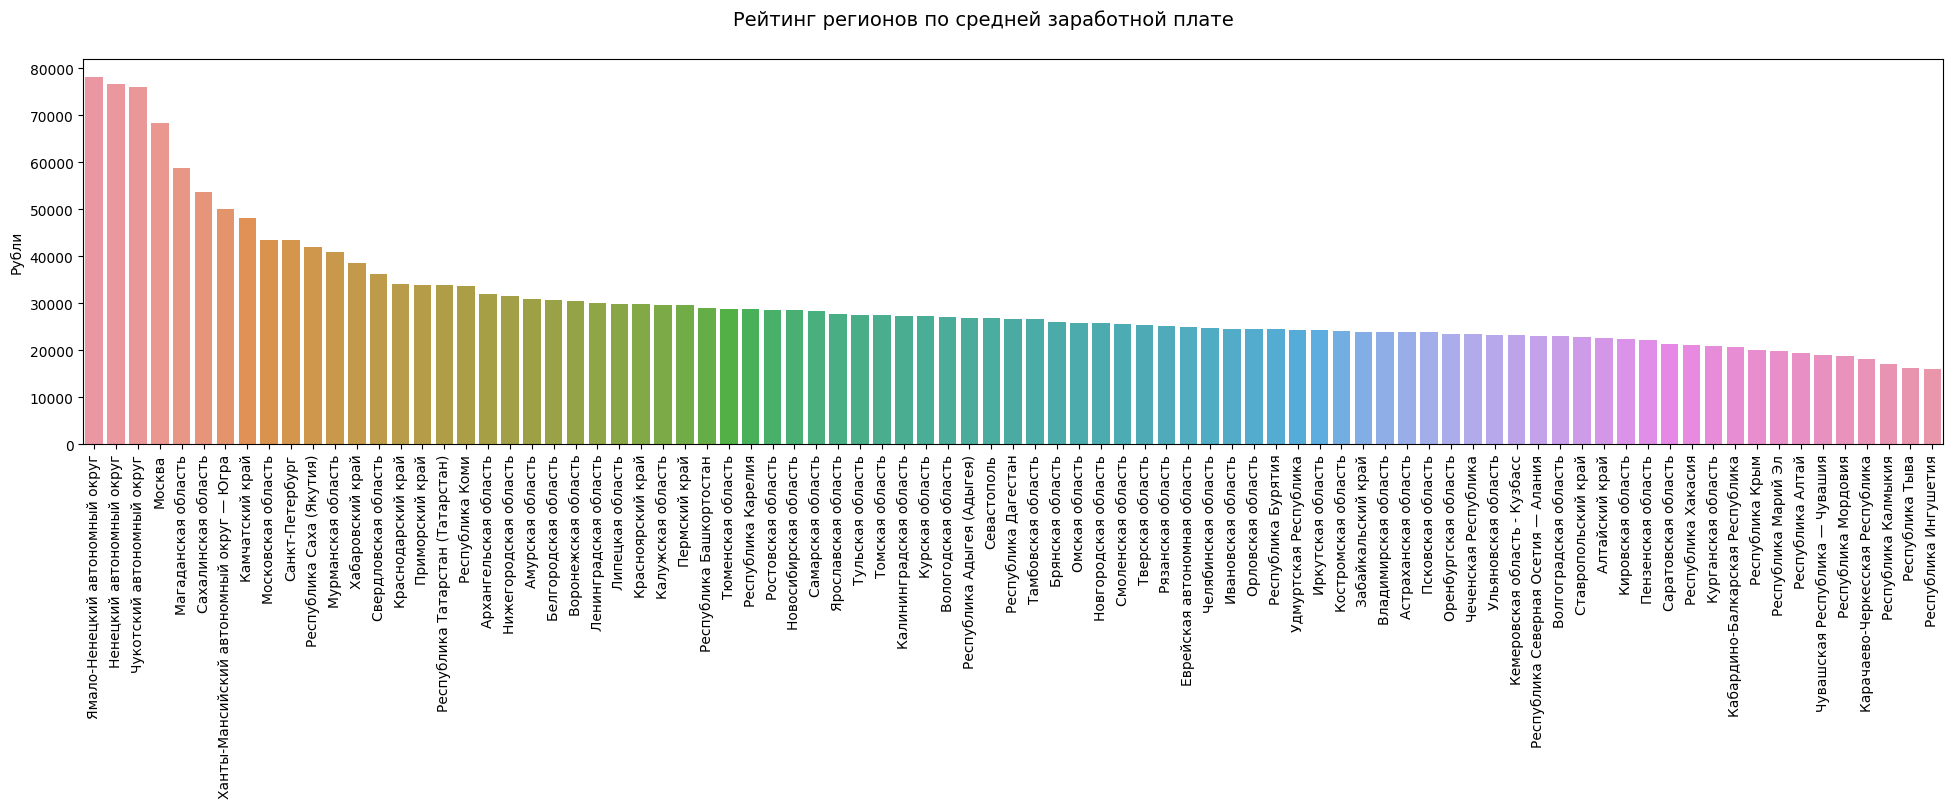

In [39]:
top_cash = df_region.sort_values(by='cash capita', ascending=False)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=top_cash, x=top_cash.index, y='cash capita')
fig.suptitle(
    'Рейтинг регионов по средней заработной плате',
    fontsize=14)
plt.xlabel('')
plt.ylabel('Рубли')
plt.xticks(rotation = 90)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]),
 [Text(0, 0, 'Москва'),
  Text(1, 0, 'Сахалинская область'),
  Text(2, 0, 'Московская область'),
  Text(3, 0, 'Свердловская область'),
  Text(4, 0, 'Санкт-Петербург'),
  Text(5, 0, 'Ямало-Ненецкий автономный округ'),
  Text(6, 0, 'Тюменская область'),
  Text(7, 0, 'Ханты-Мансийский автономный округ — Югра'),
  Text(8, 0, 'Краснодарский край'),
  Text(9, 0, 'Хабаровский край'),
  Text(10, 0, 'Республика Татарстан (Татарстан)'),
  Text(11, 0, 'Воронежская область'),
  Text(12, 0, 'Республика Саха (Якутия)'),
  Text(13, 0, 'Мурманская область'),
  Text(14, 0, 'Нижегородская область'),
  Text(15, 0, 'Архангельская 

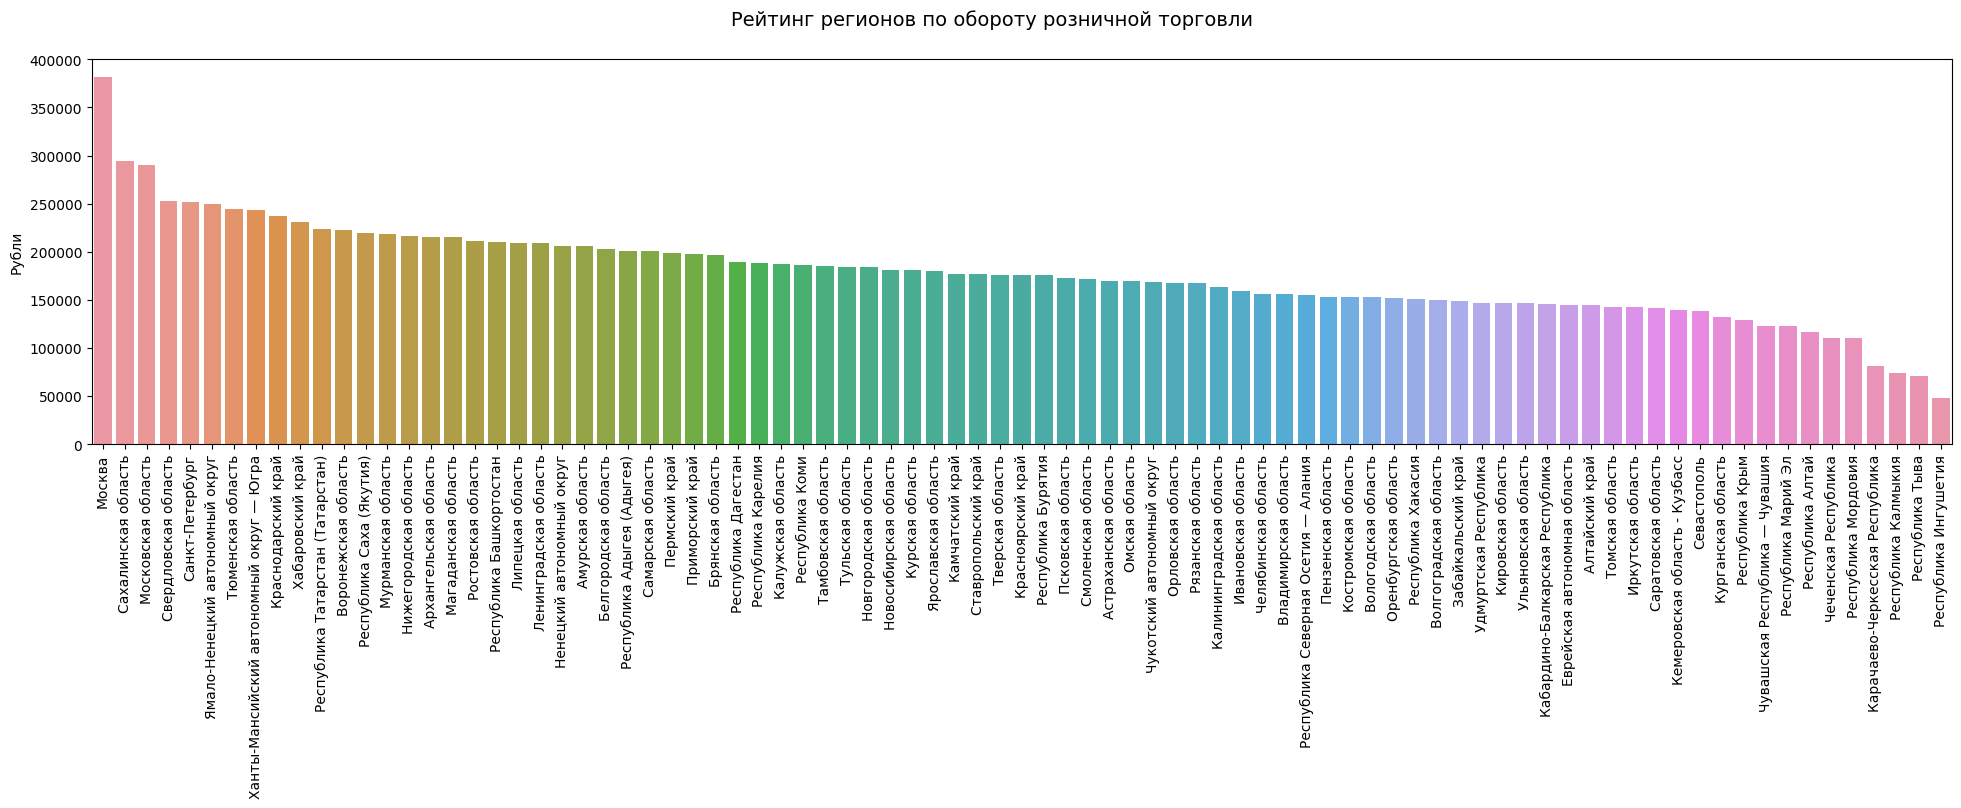

In [40]:
top_retail = df_region.sort_values(by='retail per capita', ascending=False)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=top_retail, x=top_retail.index, y='retail per capita')
fig.suptitle(
    'Рейтинг регионов по обороту розничной торговли',
    fontsize=14)
plt.xlabel('')
plt.ylabel('Рубли')
plt.xticks(rotation = 90)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]),
 [Text(0, 0, 'Республика Ингушетия'),
  Text(1, 0, 'Брянская область'),
  Text(2, 0, 'Республика Дагестан'),
  Text(3, 0, 'Ненецкий автономный округ'),
  Text(4, 0, 'Республика Калмыкия'),
  Text(5, 0, 'Республика Мордовия'),
  Text(6, 0, 'Воронежская область'),
  Text(7, 0, 'Тамбовская область'),
  Text(8, 0, 'Республика Адыгея (Адыгея)'),
  Text(9, 0, 'Смоленская область'),
  Text(10, 0, 'Чеченская Республика'),
  Text(11, 0, 'Астраханская область'),
  Text(12, 0, 'Республика Крым'),
  Text(13, 0, 'Оренбургская область'),
  Text(14, 0, 'Рязанская область'),
  Text(15, 0, 'Ставропольский край'),
  Text(16, 0, 

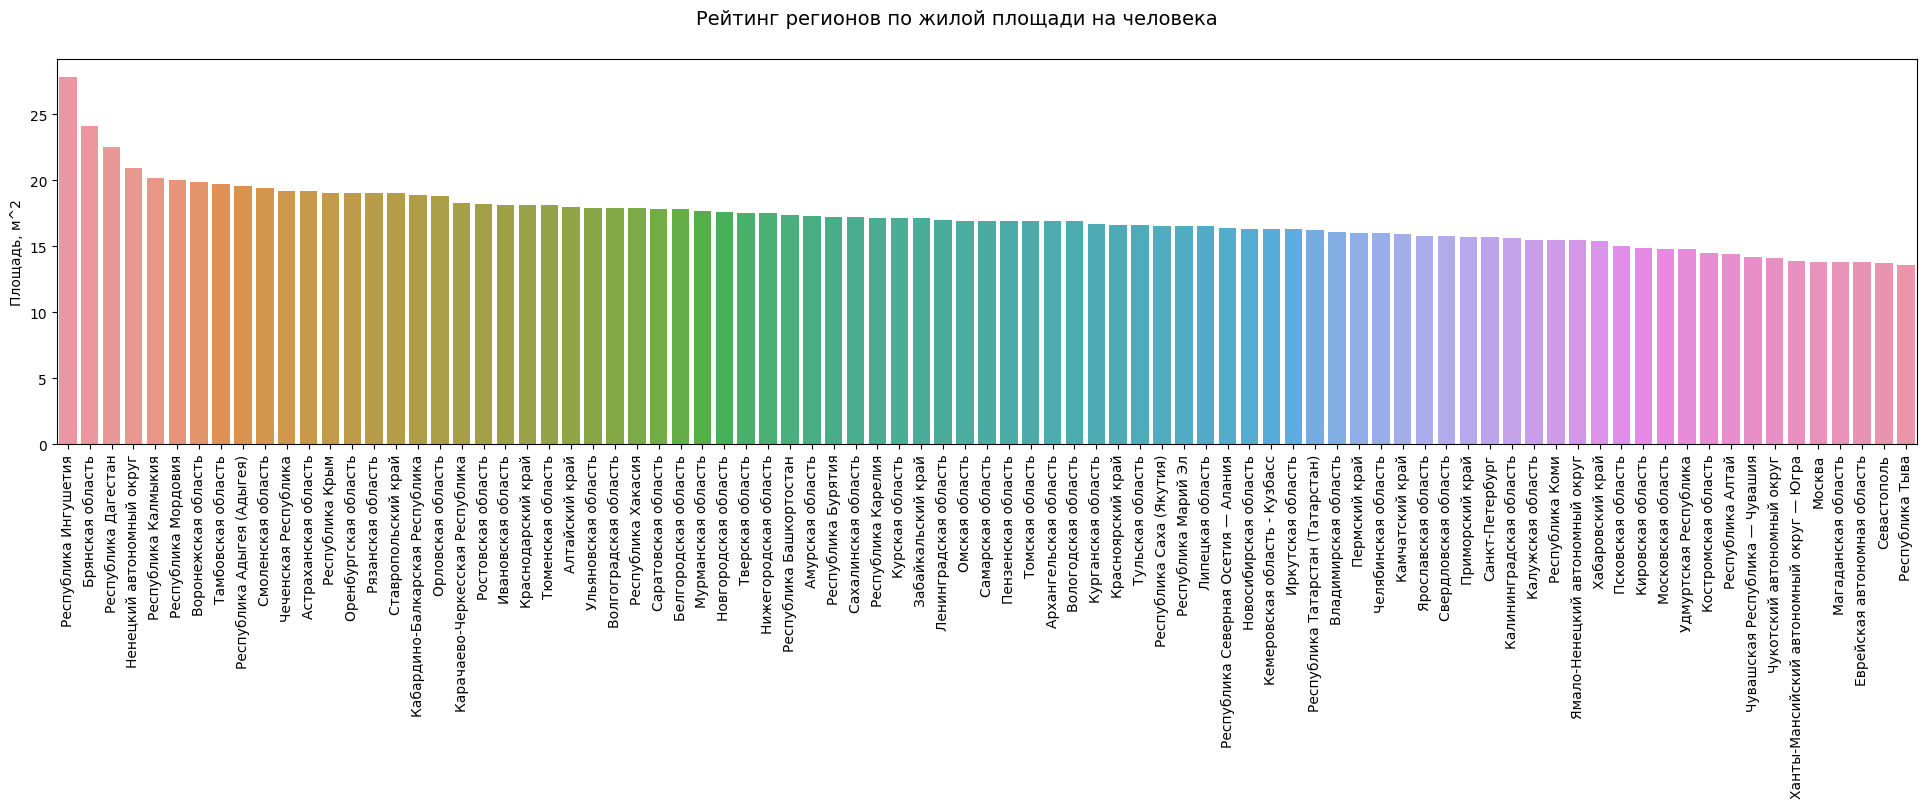

In [41]:
top_living_area = df_region.sort_values(by='living area', ascending=False)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=top_living_area, x=top_living_area.index, y='living area')
fig.suptitle(
    'Рейтинг регионов по жилой площади на человека',
    fontsize=14)
plt.xlabel('')
plt.ylabel('Площадь, м^2')
plt.xticks(rotation = 90)

Северные регионы занимают лидирующие позиции в рейтинге по уровню зарплат, благодаря активности нефтегазовой отрасли. В то же время, Москва выделяется по обороту розничной торговли, исключая её, аутсайдерами по этому показателю становятся другие регионы. Отмечается, что регионы с более тёплым климатом лидируют по общей площади жилья, за исключением Ненецкого автономного округа, Ямало-Ненецкого автономного округа и Москвы, которые занимают не самые высокие позиции в данном рейтинге.

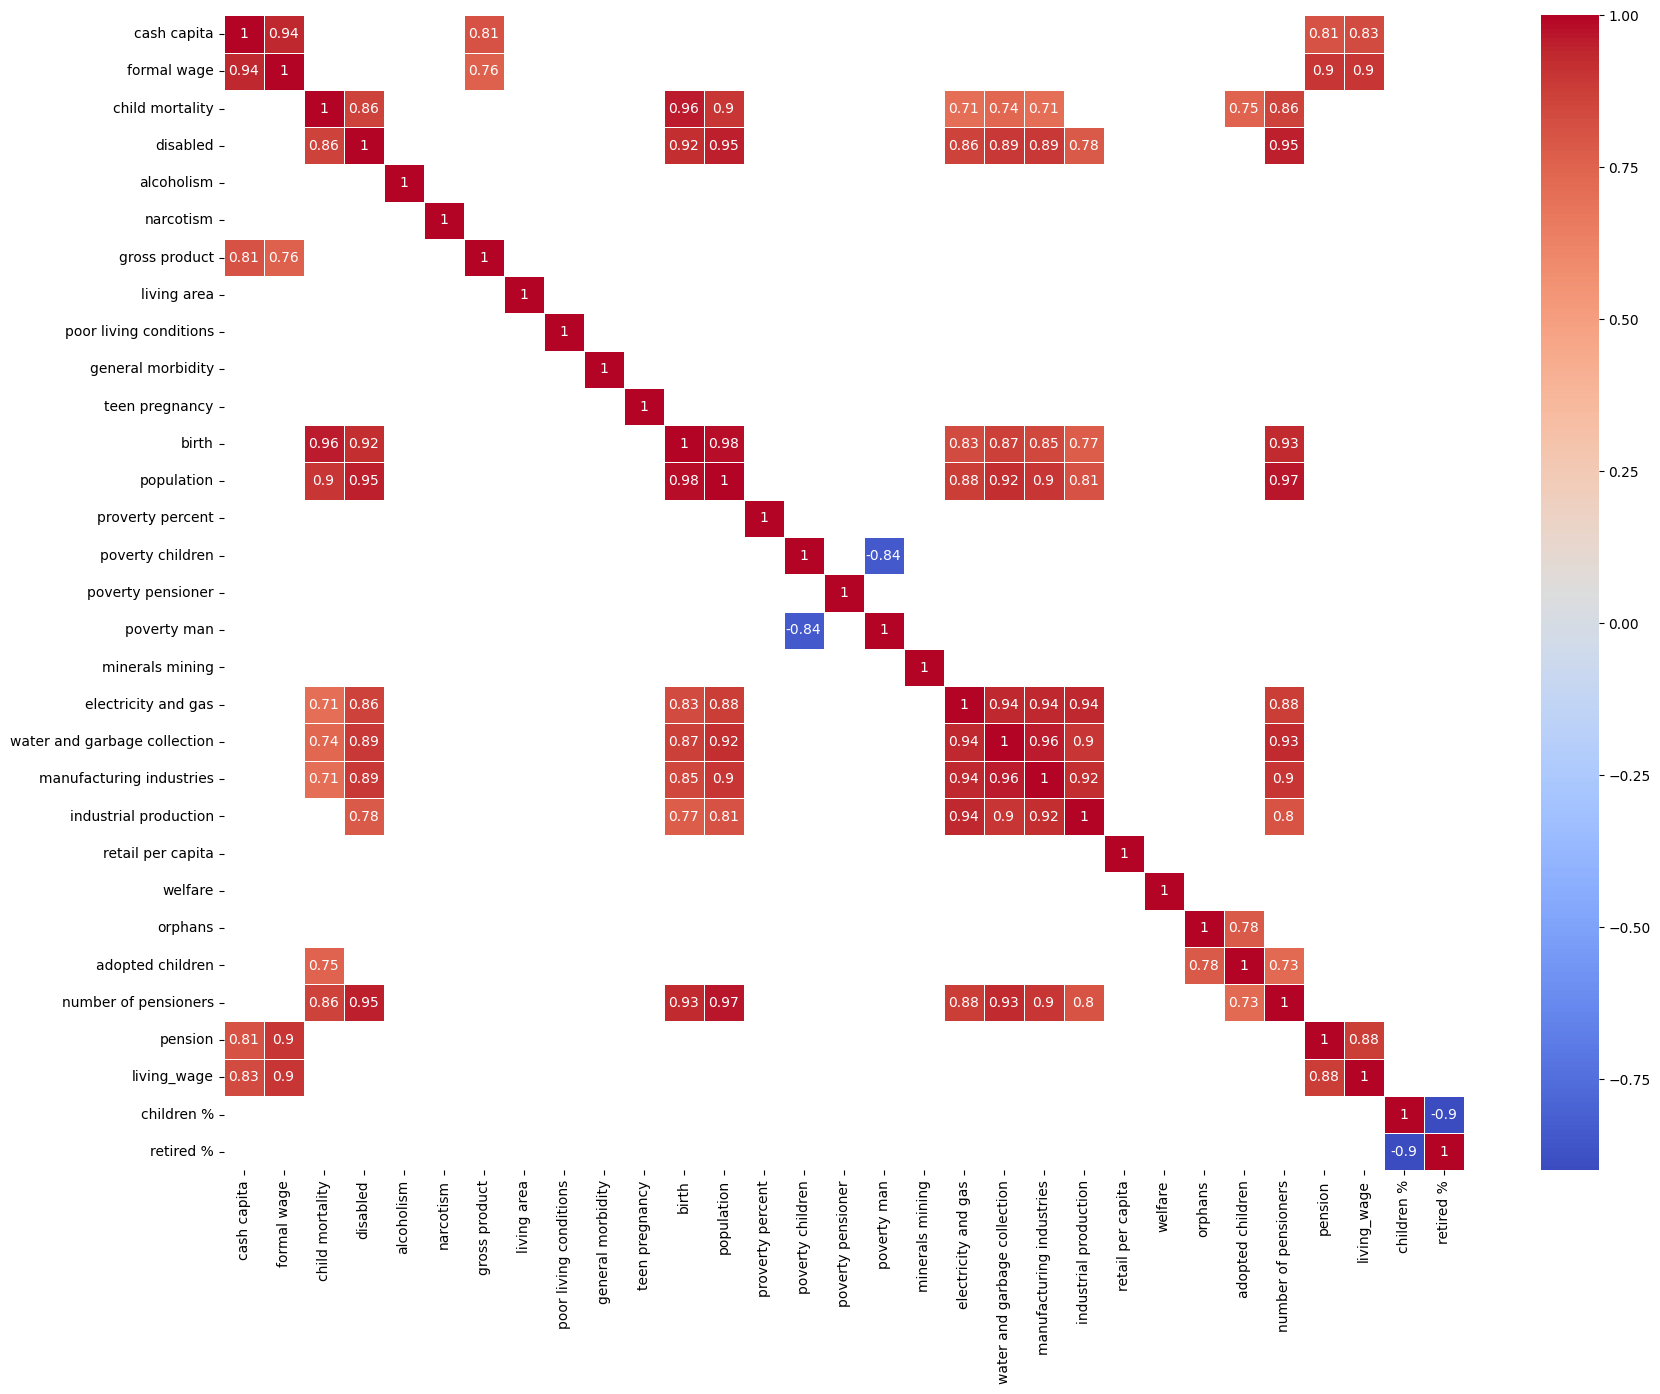

In [42]:
# Создадим тепловую карту, визуализирующую значения матрицы корреляции всех пар переменных
plt.figure(figsize=(20, 15))
corr_matrix = df_region.corr().round(decimals=2)
sns.heatmap(corr_matrix[(corr_matrix > 0.7) | (corr_matrix < -0.7)], annot=True, cmap='coolwarm', linewidths=.5)
plt.show()

1. Все показатели "Объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами" демонстрируют чрезвычайно высокую взаимосвязь, колеблясь от 0.9 до 0.95. В связи с этим, для упрощения анализа, рекомендуется оставить только один из них.
2. Кроме того, указанные выше признаки проявляют очень сильную корреляцию с численностью пенсионеров, количеством инвалидов и уровнем рождаемости, превышающую 0.9. Все эти параметры тесно взаимосвязаны между собой.
3. Наблюдается выраженная обратная корреляция между количеством детей и взрослых, находящихся в категории малоимущих. Возможно, бедные семьи реже имеют потомство, что подчёркивает этот показатель.
4. Весьма высокий уровень обратной корреляции выявлен между оборотом розничной торговли и процентом населения, проживающего за чертой бедности. Аналогичные тенденции замечены и в связи с уровнем среднемесячного дохода, что подчеркивает сильную обратную зависимость от процента населения, живущего в бедности.

In [43]:
df_region['cash capita norm'] = df_region['cash capita'] / df_region['living_wage']
df_region['formal wage norm'] = df_region['formal wage'] / df_region['living_wage']
df_region['retail norm'] = df_region['retail per capita'] / df_region['living_wage']

df_region.drop(columns=['cash capita', 'formal wage', 'retail per capita'], axis=1, inplace=True)

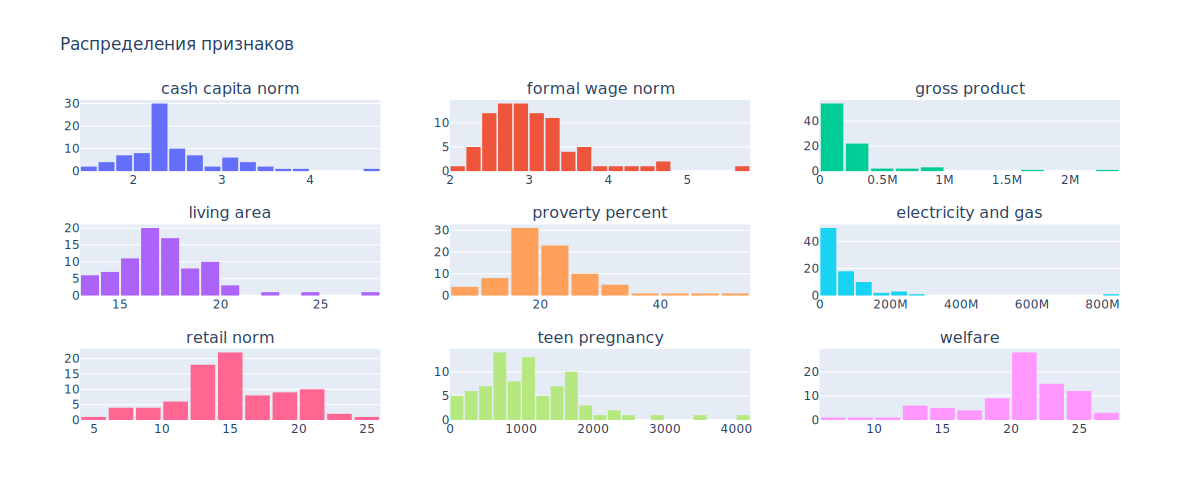

In [44]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

cols=['cash capita norm','formal wage norm','gross product','living area',
      'proverty percent','electricity and gas','retail norm', 'teen pregnancy','welfare']

# Создайте объект subplots
fig = make_subplots(rows=3, cols=3, subplot_titles=cols)

# Создайте гистограммы и добавьте их к объекту fig
for i, col in enumerate(cols):
    row = 1 if i < 3 else (2 if i < 6 else 3)
    col_num = i % 3 + 1
    fig.add_trace(go.Histogram(x=df_region[col], nbinsx=20), row=row, col=col_num)

# Обновите макет и отобразите график
fig.update_layout(title='Распределения признаков',
                  showlegend=False, width=1200, height=500)
fig.layout.bargap = 0.1
fig.show('svg')

Рекомендуется преобразовать признаки 'gross product' и 'electricity and gas' с использованием логарифмической шкалы.

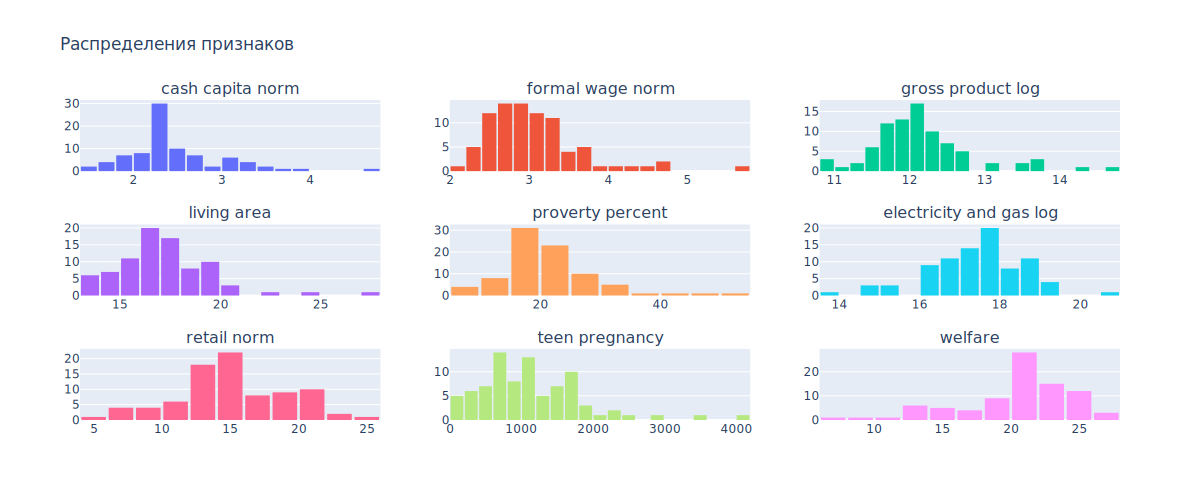

In [45]:
df_region['gross product log'] = np.log(df_region['gross product'])
df_region['electricity and gas log'] = np.log(df_region['electricity and gas'])
df_region.drop(columns=['gross product', 'electricity and gas'],axis=1, inplace=True)

cols=['cash capita norm','formal wage norm','gross product log','living area',
      'proverty percent','electricity and gas log','retail norm', 'teen pregnancy', 'welfare']

# Создайте объект subplots
fig = make_subplots(rows=3, cols=3, subplot_titles=cols)

# Создайте гистограммы и добавьте их к объекту fig
for i, col in enumerate(cols):
    row = 1 if i < 3 else (2 if i < 6 else 3)
    col_num = i % 3 + 1
    fig.add_trace(go.Histogram(x=df_region[col], nbinsx=20), row=row, col=col_num)

# Обновите макет и отобразите график
fig.update_layout(title='Распределения признаков',
                  showlegend=False, width=1200, height=500)
fig.layout.bargap = 0.1
fig.show('svg')

In [46]:
#Упорядочим колонки

cols=['cash capita norm','formal wage norm','gross product log','living area',
      'proverty percent','electricity and gas log','retail norm', 'teen pregnancy', 'welfare']

df_region = df_region[cols].copy()

In [47]:
for col in df_region.columns:
    _, p = shapiro(df_region[col])
    print(f'{col}:   p-value = {p:.3f}')

cash capita norm:   p-value = 0.000
formal wage norm:   p-value = 0.000
gross product log:   p-value = 0.000
living area:   p-value = 0.000
proverty percent:   p-value = 0.000
electricity and gas log:   p-value = 0.342
retail norm:   p-value = 0.475
teen pregnancy:   p-value = 0.000
welfare:   p-value = 0.000


Распределение данных не соответствует нормальному; наиболее близкими к нормальному являются графики "electricity and gas log" и "retail norm". В связи с отсутствием нормальности в распределениях мы рассмотрим ранговую матрицу для коэффициентов Спирмена и Кендалла.

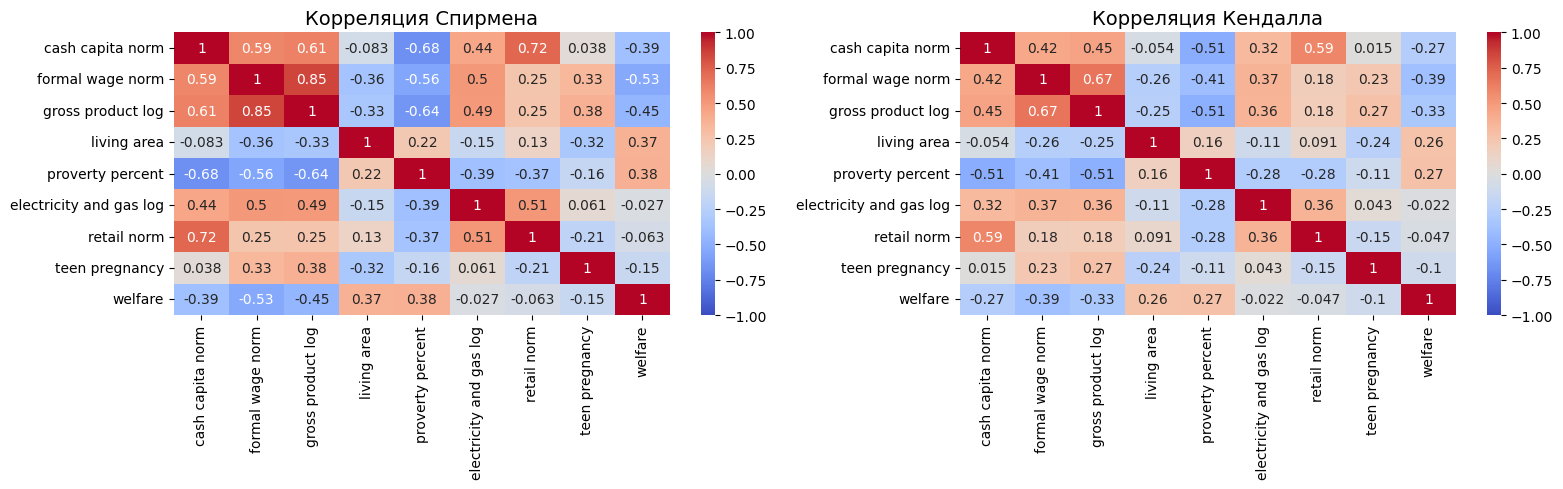

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.heatmap(df_region.corr(method='spearman'), 
            annot=True, cmap='coolwarm', vmin=-1, ax=ax[0])
sns.heatmap(df_region.corr(method='kendall'), 
            annot=True, cmap='coolwarm', vmin=-1, ax=ax[1])
ax[0].set_title('Корреляция Спирмена', fontsize=14)
ax[1].set_title('Корреляция Кендалла', fontsize=14)
plt.tight_layout()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/

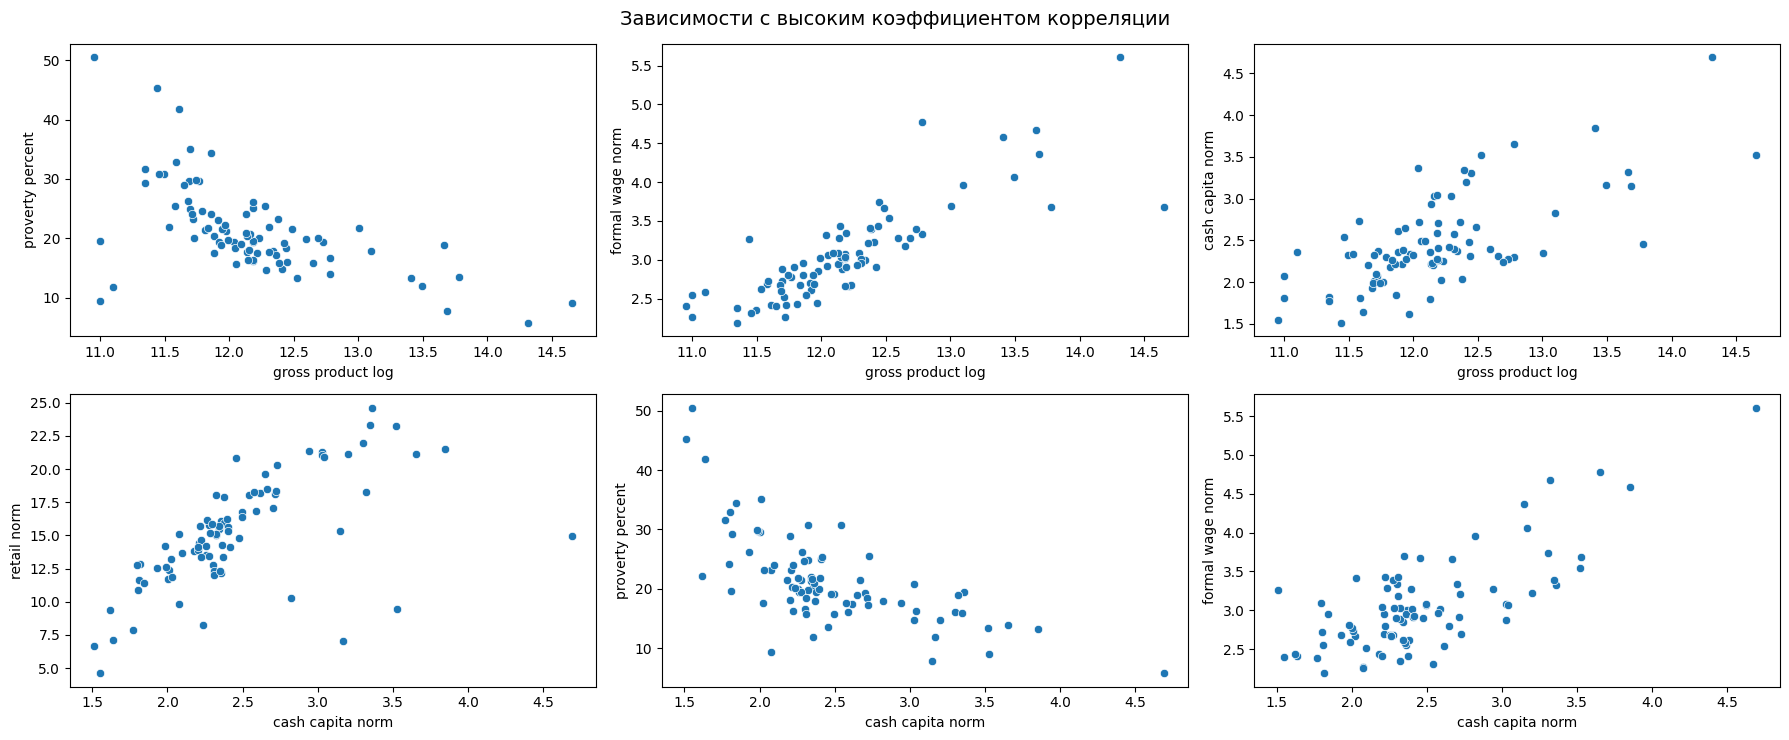

In [49]:
# Создайте сетку графиков
fig, axes = plt.subplots(2, 3, figsize=(18, 7.5))

# Список пар столбцов для создания scatterplot
pairs = [('gross product log', 'proverty percent'),
         ('gross product log', 'formal wage norm'),
         ('gross product log', 'cash capita norm'),
         ('cash capita norm', 'retail norm'),
         ('cash capita norm', 'proverty percent'),
         ('cash capita norm', 'formal wage norm')]

# Создайте графики в цикле
for i, pair in enumerate(pairs):
    row = i // 3
    col = i % 3
    sns.scatterplot(data=df_region, x=pair[0], y=pair[1], ax=axes[row, col])

# Установите общее заголовок
plt.suptitle('Зависимости с высоким коэффициентом корреляции', fontsize=14)

# Уточните макет
plt.tight_layout()

# Показать графики
plt.show()

Обнаружена лишь одна очень высокая корреляция между 'gross product log' и 'formal wage norm', которая составляет 82 (по Кендаллу - 0.66). Остальные признаки не превышают уровень 0.72, исходя из чего делаю вывод, что удаление признаков не является необходимым.

После этого проведем масштабирование признаков с использованием метода MinMaxScaler:

In [50]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df_region)

## 3. Кластеризация

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

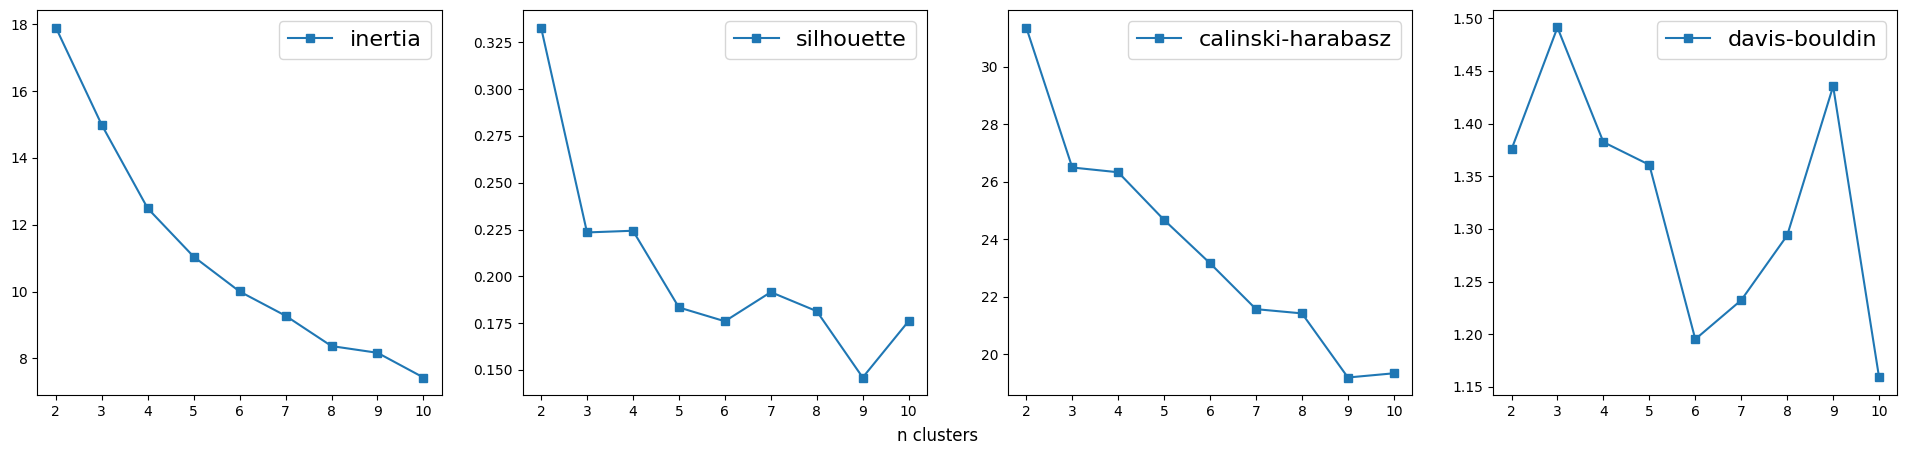

In [51]:
def plot_metrics(X):
    """Построение графиков кластеризации в зависимости от количества кластеров"""
    inertia = []
    silhouette = []
    calinski_harabasz = []
    davis_bouldin = []
    
    for n_cl in range(2, 11):
        kmeans = cluster.KMeans(n_clusters=n_cl, random_state=42)
        kmeans.fit(X)
    
        inertia.append(kmeans.inertia_)
        silhouette.append(metrics.silhouette_score(
            X, kmeans.labels_))
        calinski_harabasz.append(metrics.calinski_harabasz_score(
            X, kmeans.labels_))
        davis_bouldin.append(metrics.davies_bouldin_score(
            X, kmeans.labels_))
        
    fig, ax = plt.subplots(1, 4, figsize=(24,5))
    
    ax[0].plot(range(2, 11), inertia, 's-', label='inertia')
    ax[1].plot(range(2, 11), silhouette, 's-', label='silhouette')
    ax[2].plot(range(2, 11), calinski_harabasz, 's-', label='calinski-harabasz')
    ax[3].plot(range(2, 11), davis_bouldin, 's-', label='davis-bouldin')
    ax[0].legend(prop={'size': 16})
    ax[1].legend(prop={'size': 16})
    ax[2].legend(prop={'size': 16})
    ax[3].legend(prop={'size': 16});
    fig.supxlabel('n clusters')
    
        
plot_metrics(X)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette: 0.224
Calinski-Harabatz: 26.335
Davis-Bouldin: 1.382


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



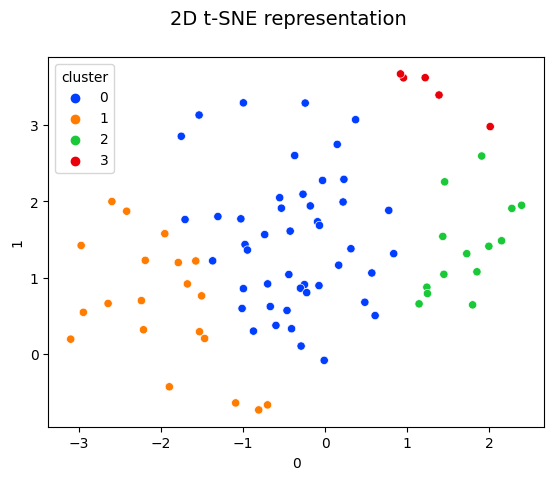

In [52]:
def plot_results(X, labels):
    "Построение 2D t-SNE представление и вычисление метрик"
    tsne = TSNE(n_components=2, perplexity=50, init='pca',
                learning_rate='auto', random_state=42)
    df_tsne = pd.DataFrame(tsne.fit_transform(X))
    df_tsne['cluster'] = labels
    fig = plt.figure()
    sns.scatterplot(x=df_tsne[0], y=df_tsne[1],
                    hue=df_tsne['cluster'], palette='bright')
    fig.suptitle('2D t-SNE representation', fontsize=14);

    print('Silhouette: {:.3f}'.format(
        metrics.silhouette_score(X, labels)))
    print('Calinski-Harabatz: {:.3f}'.format(
        metrics.calinski_harabasz_score(X, labels)))
    print('Davis-Bouldin: {:.3f}'.format(
        metrics.davies_bouldin_score(X, labels)))
        

kmeans = cluster.KMeans(n_clusters=4, random_state=42)
bm_labels = kmeans.fit_predict(X)
plot_results(X, bm_labels)

Число главных компонент: 5


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

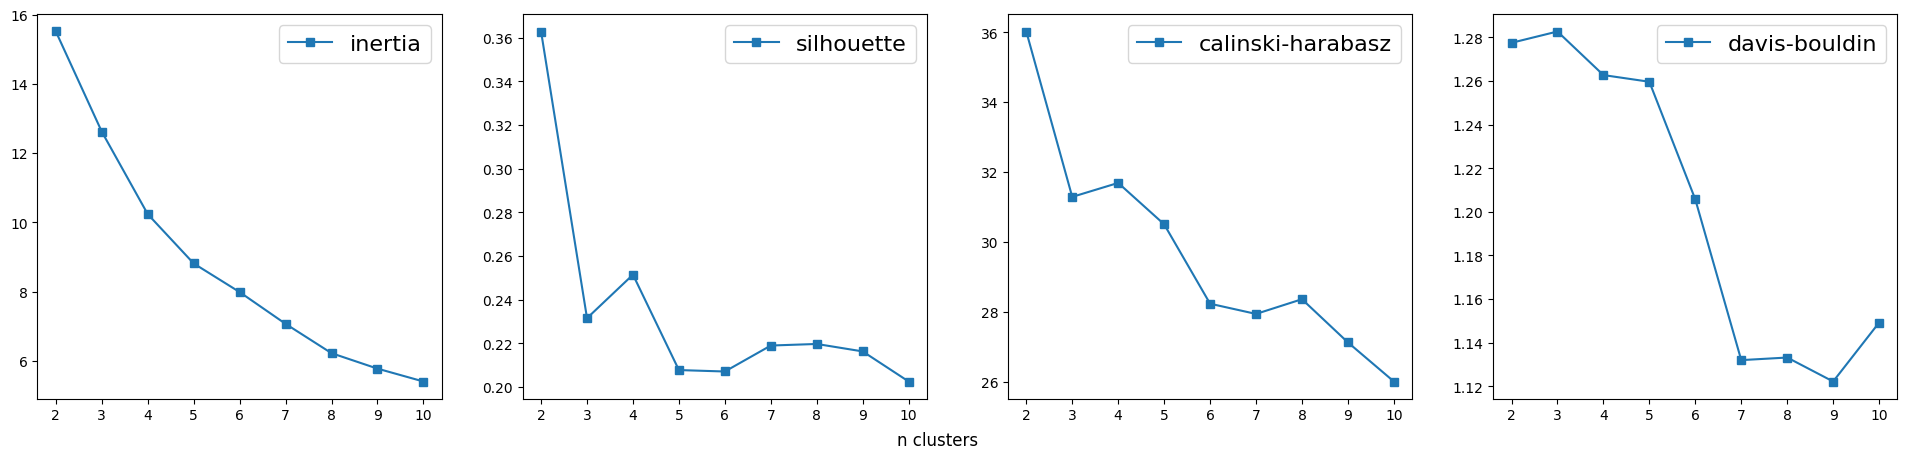

In [55]:
pca = PCA(n_components=0.9)  # 90% of explained dispersion
X_pca = pca.fit_transform(X)
print(f'Число главных компонент: {pca.n_components_}')

plot_metrics(X_pca)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette: 0.251
Calinski-Harabatz: 31.689
Davis-Bouldin: 1.263
Rand score (сравнение с базовой моделью): 0.942017


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



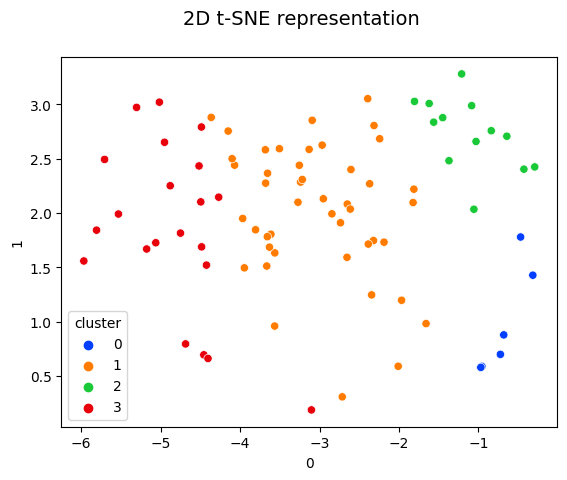

In [56]:
kmeans_pca = cluster.KMeans(n_clusters=4, random_state=42)
kmeans_pca.fit_predict(X_pca)
plot_results(X_pca, kmeans_pca.labels_)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, kmeans_pca.labels_)))

In [57]:
fig = px.scatter_3d(
    x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
    title='Кластеры в пространстве трех главных компонент (PCA)',
    color=kmeans_pca.labels_, width=650, height=400)
fig.update_traces(marker={'size':3}, marker_line_width=0.5)
fig.show()

Silhouette: 0.267
Calinski-Harabatz: 22.778
Davis-Bouldin: 1.392
Rand score (сравнение с базовой моделью): 0.630812


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



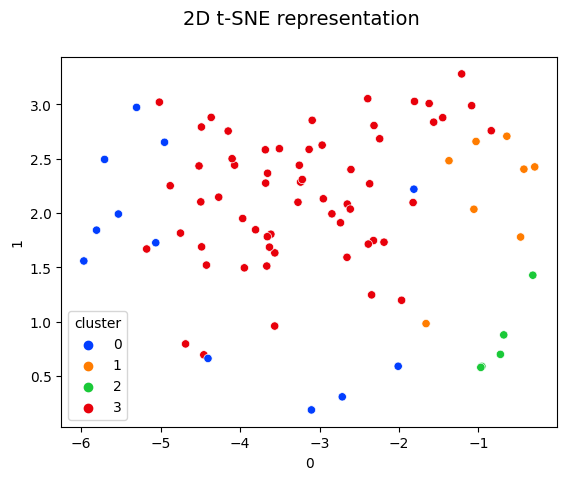

In [58]:
# Гауссова смесь, наилучший вариант: covariance_type='tied'
gmix = GaussianMixture(
    n_components=4, random_state=42, covariance_type='tied')
labels = gmix.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, labels)))

Silhouette: 0.301
Calinski-Harabatz: 28.549
Davis-Bouldin: 1.037
Rand score (сравнение с базовой моделью): 0.788796


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



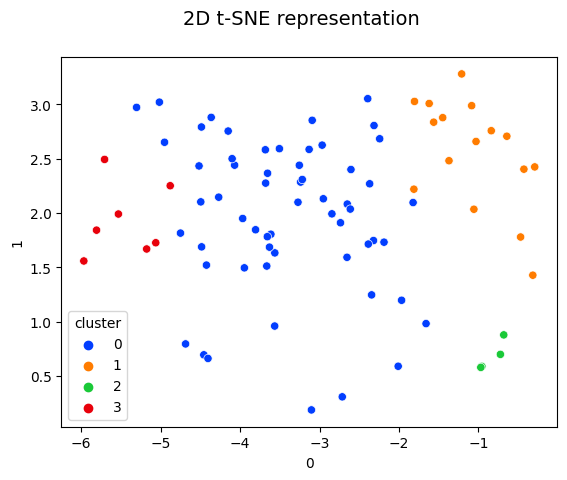

In [59]:
# Агломеративная кластеризация, наилучший вариант: linkage='ward'
tree_like = cluster.AgglomerativeClustering(n_clusters=4, linkage='ward')
labels = tree_like.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, labels)))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Silhouette: 0.205
Calinski-Harabatz: 24.787
Davis-Bouldin: 0.882
Rand score (сравнение с базовой моделью): 0.712605


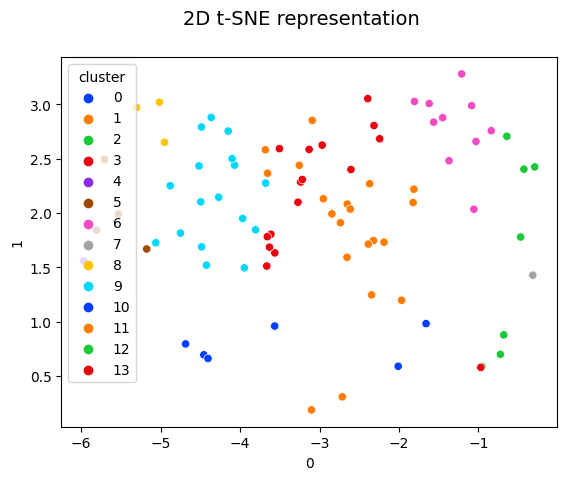

In [60]:
# Метод распространения близости
aff_prop = cluster.AffinityPropagation(damping=0.9, random_state=42)
labels = aff_prop.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, labels)))

Silhouette: 0.287
Calinski-Harabatz: 28.067
Davis-Bouldin: 1.158
Rand score (сравнение с базовой моделью): 0.782073


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



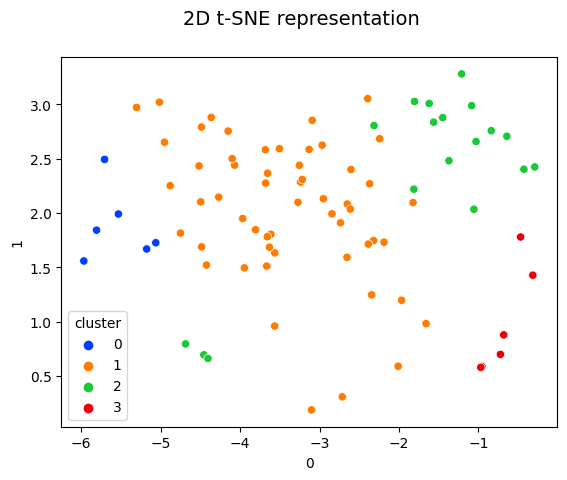

In [61]:
spectral = cluster.SpectralClustering(n_clusters=4)
labels = spectral.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, labels)))

In [64]:
# Гауссова смесь, наилучший вариант: covariance_type='tied'
gmix = GaussianMixture(
    n_components=4, random_state=42, covariance_type='tied')
labels_gmix = gmix.fit_predict(X_pca)
df_region['cluster'] = labels_gmix

# Упорядочим нумерацию кластеров 
df_region['cluster'] = df_region['cluster'].replace({2:0, 0:1, 3:2, 1:3})
df_region.to_csv('data/regions_cluster.csv')
df_region['cluster'].to_csv('data/labels.csv')

fig = px.scatter_3d(
    x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
    title='Кластеры в пространстве трех главных компонент (PCA)',
    color=df_region['cluster'], width=650, height=400)
fig.update_traces(marker={'size':3}, marker_line_width=0.5)
fig.show()